# Introduction to Tree-based methods (with external dependencies)

Written by:
- Manuel Szewc (School of Physics, University of Cincinnati)
- Philip Ilten (School of Physics, University of Cincinnati)
$\renewcommand{\gtrsim}{\raisebox{-2mm}{\hspace{1mm}$\stackrel{>}{\sim}$\hspace{1mm}}}\renewcommand{\lessim}{\raisebox{-2mm}{\hspace{1mm}$\stackrel{<}{\sim}$\hspace{1mm}}}\renewcommand{\as}{\alpha_{\mathrm{s}}}\renewcommand{\aem}{\alpha_{\mathrm{em}}}\renewcommand{\kT}{k_{\perp}}\renewcommand{\pT}{p_{\perp}}\renewcommand{\pTs}{p^2_{\perp}}\renewcommand{\pTe}{\p_{\perp\mrm{evol}}}\renewcommand{\pTse}{\p^2_{\perp\mrm{evol}}}\renewcommand{\pTmin}{p_{\perp\mathrm{min}}}\renewcommand{\pTsmim}{p^2_{\perp\mathrm{min}}}\renewcommand{\pTmax}{p_{\perp\mathrm{max}}}\renewcommand{\pTsmax}{p^2_{\perp\mathrm{max}}}\renewcommand{\pTL}{p_{\perp\mathrm{L}}}\renewcommand{\pTD}{p_{\perp\mathrm{D}}}\renewcommand{\pTA}{p_{\perp\mathrm{A}}}\renewcommand{\pTsL}{p^2_{\perp\mathrm{L}}}\renewcommand{\pTsD}{p^2_{\perp\mathrm{D}}}\renewcommand{\pTsA}{p^2_{\perp\mathrm{A}}}\renewcommand{\pTo}{p_{\perp 0}}\renewcommand{\shat}{\hat{s}}\renewcommand{\a}{{\mathrm a}}\renewcommand{\b}{{\mathrm b}}\renewcommand{\c}{{\mathrm c}}\renewcommand{\d}{{\mathrm d}}\renewcommand{\e}{{\mathrm e}}\renewcommand{\f}{{\mathrm f}}\renewcommand{\g}{{\mathrm g}}\renewcommand{\hrm}{{\mathrm h}}\renewcommand{\lrm}{{\mathrm l}}\renewcommand{\n}{{\mathrm n}}\renewcommand{\p}{{\mathrm p}}\renewcommand{\q}{{\mathrm q}}\renewcommand{\s}{{\mathrm s}}\renewcommand{\t}{{\mathrm t}}\renewcommand{\u}{{\mathrm u}}\renewcommand{\A}{{\mathrm A}}\renewcommand{\B}{{\mathrm B}}\renewcommand{\D}{{\mathrm D}}\renewcommand{\F}{{\mathrm F}}\renewcommand{\H}{{\mathrm H}}\renewcommand{\J}{{\mathrm J}}\renewcommand{\K}{{\mathrm K}}\renewcommand{\L}{{\mathrm L}}\renewcommand{\Q}{{\mathrm Q}}\renewcommand{\R}{{\mathrm R}}\renewcommand{\T}{{\mathrm T}}\renewcommand{\W}{{\mathrm W}}\renewcommand{\Z}{{\mathrm Z}}\renewcommand{\bbar}{\overline{\mathrm b}}\renewcommand{\cbar}{\overline{\mathrm c}}\renewcommand{\dbar}{\overline{\mathrm d}}\renewcommand{\fbar}{\overline{\mathrm f}}\renewcommand{\pbar}{\overline{\mathrm p}}\renewcommand{\qbar}{\overline{\mathrm q}}\renewcommand{\rbar}{\overline{\mathrm{r}}}\renewcommand{\sbar}{\overline{\mathrm s}}\renewcommand{\tbar}{\overline{\mathrm t}}\renewcommand{\ubar}{\overline{\mathrm u}}\renewcommand{\Bbar}{\overline{\mathrm B}}\renewcommand{\Fbar}{\overline{\mathrm F}}\renewcommand{\Qbar}{\overline{\mathrm Q}}\renewcommand{\tms}{{t_{\mathrm{\tiny MS}}}}\renewcommand{\Oas}[1]{{\mathcal{O}\left(\as^{#1}\right)}}$

This notebook wants to implement decision trees, random forests and gradient boosting. A lot of it is based on [Aurelien Geron's lectures](https://github.com/ageron/handson-ml3).


In [1]:
import os
import sys

# To generate data and handle arrays
import numpy as np

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

In [2]:
import pandas as pd
import cv2 #pip install opencv-python
%matplotlib inline
from scipy.stats import norm, multivariate_normal

#Useful classes for data manipulation
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures 

# Useful classes for model evaluation and selection
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score,confusion_matrix, mean_squared_error 

# a baseline classifier
from sklearn.linear_model import LinearRegression, RidgeCV

# The necessary models
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

## Theory

What are decision trees?

## Classification with Decision Trees

We'll use the `sklearn` implementation of decision trees.

Let's use a dataset as an example 

In [3]:
if 'google.colab' in sys.modules:
        
    import tarfile
    !mkdir datasets
    DOWNLOAD_URL = ""
    !wget {DOWNLOAD_URL} -P {"datasets/"} 
    !mv {"datasets/season-1112.csv"} {"datasets/season-1112.csv"} 
else: 
    print("Not running on Google Colab. This cell is did not do anything.")

Not running on Google Colab. This cell is did not do anything.


In [4]:
df = pd.read_csv('datasets/season-1112.csv')#https://datahub.io/sports-data/english-premier-league and https://www.football-data.co.uk/notes.txt

This file has all matches of the 2011-2012 English Premier League season.
For each match, we have local and away goals both at half-time and at the end of the match. We also have the number of shots, shots on goal, fouls, yellow cards, red cards and betting odds from some known sites.

In [5]:
df.head()

Div      Date   HomeTeam     AwayTeam  FTHG  FTAG FTR  HTHG  HTAG HTR  ...  \
0  E0  13/08/11  Blackburn       Wolves     1     2   A     1     1   D  ...   
1  E0  13/08/11     Fulham  Aston Villa     0     0   D     0     0   D  ...   
2  E0  13/08/11  Liverpool   Sunderland     1     1   D     1     0   H  ...   
3  E0  13/08/11  Newcastle      Arsenal     0     0   D     0     0   D  ...   
4  E0  13/08/11        QPR       Bolton     0     4   A     0     1   A  ...   

  BbMx>2.5  BbAv>2.5  BbMx<2.5  BbAv<2.5  BbAH  BbAHh  BbMxAHH  BbAvAHH  \
0     2.06      1.96      1.89      1.82    18  -0.50     2.20     2.14   
1     2.21      2.11      1.77      1.69    21  -0.25     1.83     1.80   
2     1.92      1.85      2.01      1.92    21  -1.00     1.92     1.88   
3     1.89      1.80      2.10      1.98    20   0.50     1.84     1.79   
4     2.27      2.16      1.73      1.66    19  -0.25     2.00     1.95   

   BbMxAHA  BbAvAHA  
0     1.78     1.74  
1     2.14     2.08  
2     2.02     1.98  
3     2.16     2.10  
4     1.98     1.92  

[5 rows x 71 columns]

In [6]:
len(df)

380

In [7]:
column_names = df.columns

In [8]:
column_names

Index(['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG',
       'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC',
       'AC', 'HY', 'AY', 'HR', 'AR', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD',
       'BWA', 'GBH', 'GBD', 'GBA', 'IWH', 'IWD', 'IWA', 'LBH', 'LBD', 'LBA',
       'SBH', 'SBD', 'SBA', 'WHH', 'WHD', 'WHA', 'SJH', 'SJD', 'SJA', 'VCH',
       'VCD', 'VCA', 'BSH', 'BSD', 'BSA', 'Bb1X2', 'BbMxH', 'BbAvH', 'BbMxD',
       'BbAvD', 'BbMxA', 'BbAvA', 'BbOU', 'BbMx>2.5', 'BbAv>2.5', 'BbMx<2.5',
       'BbAv<2.5', 'BbAH', 'BbAHh', 'BbMxAHH', 'BbAvAHH', 'BbMxAHA',
       'BbAvAHA'],
      dtype='object')

We can play with this.

One possibility is trying to predict a winner based on all other features.

Let's make a copy before further processingHagamos una copia antes de empezar

In [9]:
df_copy=df.copy()#[['HomeTeam','AwayTeam', 'FTHG','FTAG','FTR','HTHG', 'HTAG', 'HTR','HS','AS','HST', 'AST','HF','AF', 'HY', 'AY', 'HR', 'AR']]

In [10]:
df_copy_train, df_copy_test = train_test_split(df_copy)

Let's explore the data to try and understand how a Decision Tree works.

To plot, let's look at only two features for now.

In [11]:
target_train=np.zeros(len(df_copy_train))
target_train[df_copy_train['FTR']=='H']=1.0
target_train[df_copy_train['FTR']=='D']=0.0
target_train[df_copy_train['FTR']=='A']=-1.0
features_train=np.asarray(df_copy_train[['FTHG','FTAG']])

target_test=np.zeros(len(df_copy_test))
target_test[df_copy_test['FTR']=='H']=1.0
target_test[df_copy_test['FTR']=='D']=0.0
target_test[df_copy_test['FTR']=='A']=-1.0
features_test=np.asarray(df_copy_test[['FTHG','FTAG']])

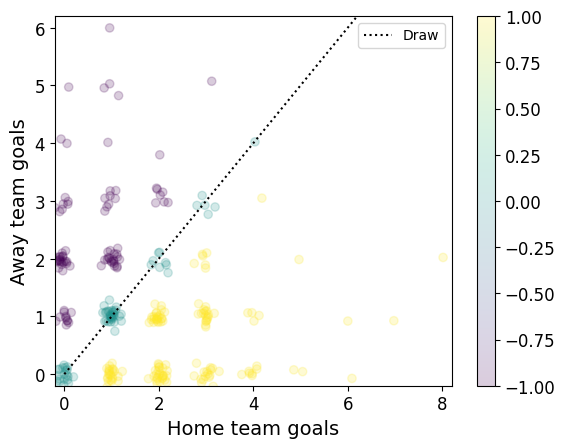

In [12]:
features_scatter=features_train+0.1*np.random.randn(len(features_train),2)
plt.scatter(features_scatter[:,0],features_scatter[:,1],c=target_train,alpha=0.2)
plt.colorbar()
xvals=np.linspace(0.0,8.0,10)
plt.plot(xvals,xvals,linestyle='dotted', color='black',label='Draw')
plt.xlabel('Home team goals')
plt.ylabel('Away team goals')
plt.xlim(-0.2,8.2)
plt.ylim(-0.2,6.2)
plt.legend(loc='upper right')

Let's forget about all the DT hyperparameters for now and just train a naive classifier:

In [13]:
dt = DecisionTreeClassifier(max_depth=None)
dt.fit(features_train,target_train)

DecisionTreeClassifier()

And let's see how it works:

In [14]:
dt.predict(np.asarray([1.0,2.0]).reshape(1,-1))

array([-1.])

/tmp/ipykernel_83477/2382861481.py:5: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contourf(xvals,yvals,Z, levels=[-1.5,-0.5,0.5,1.5],label='DT')


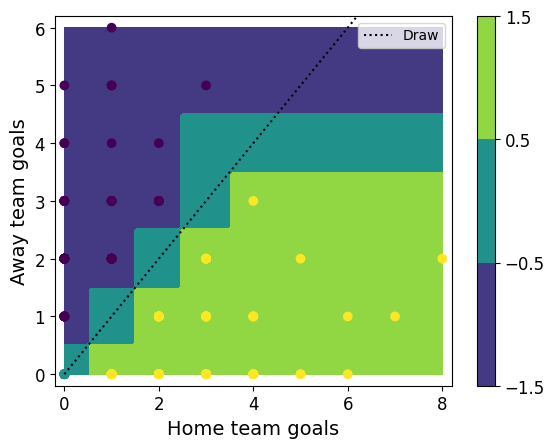

In [15]:
xvals=np.linspace(0.0,8.0,100)
yvals=np.linspace(0.0,6.0,100)
X, Y = np.meshgrid(xvals,yvals)
Z = dt.predict(np.c_[X.ravel(),Y.ravel()]).reshape(X.shape)
plt.contourf(xvals,yvals,Z, levels=[-1.5,-0.5,0.5,1.5],label='DT')
plt.colorbar()
plt.scatter(features_train[:,0],features_train[:,1],c=target_train)
plt.plot(xvals,xvals,linestyle='dotted', color='black',label='Draw')
plt.xlabel('Home team goals')
plt.ylabel('Away team goals')
plt.xlim(-0.2,8.2)
plt.ylim(-0.2,6.2)
plt.legend(loc='upper right')

It's really overfitting! Weird looking curves.

We wouldn't be able to tell from the confusion matrix though...

In [16]:
print(confusion_matrix(target_train,dt.predict(features_train)))
print(confusion_matrix(target_test,dt.predict(features_test)))

[[ 84   0   0]
 [  0  67   0]
 [  0   0 134]]
[[32  0  0]
 [ 0 26  0]
 [ 0  0 37]]


But an inspection of the defined tree would show it:

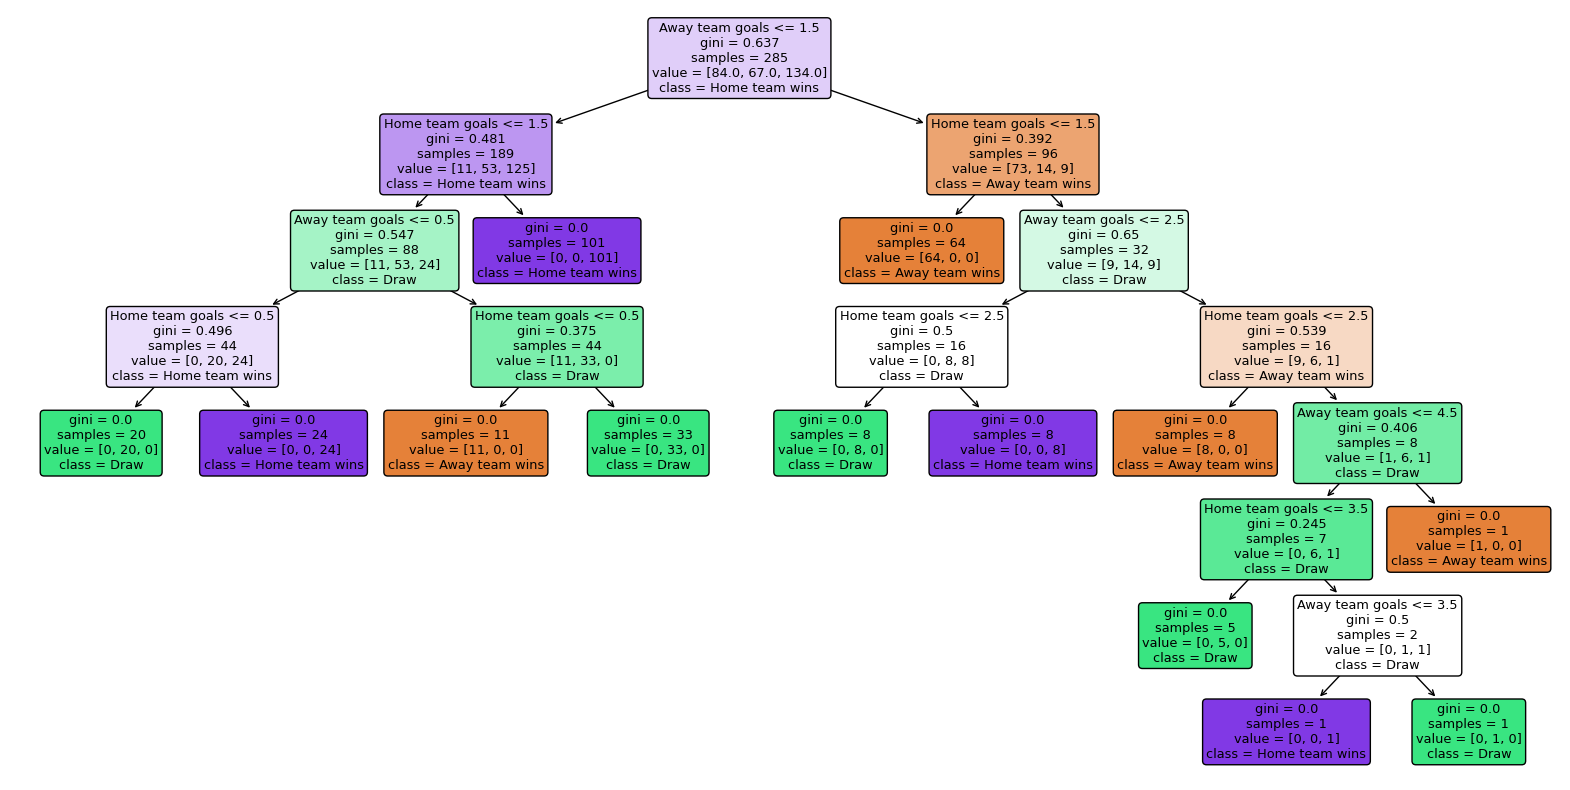

In [17]:
plt.figure(figsize=(20,10))
tree.plot_tree(dt,filled=True,rounded=True,feature_names=["Home team goals","Away team goals"],class_names=["Away team wins","Draw","Home team wins"]) 
plt.show()

This plot can also be exported as a `.dot` file and saved as `.png`.

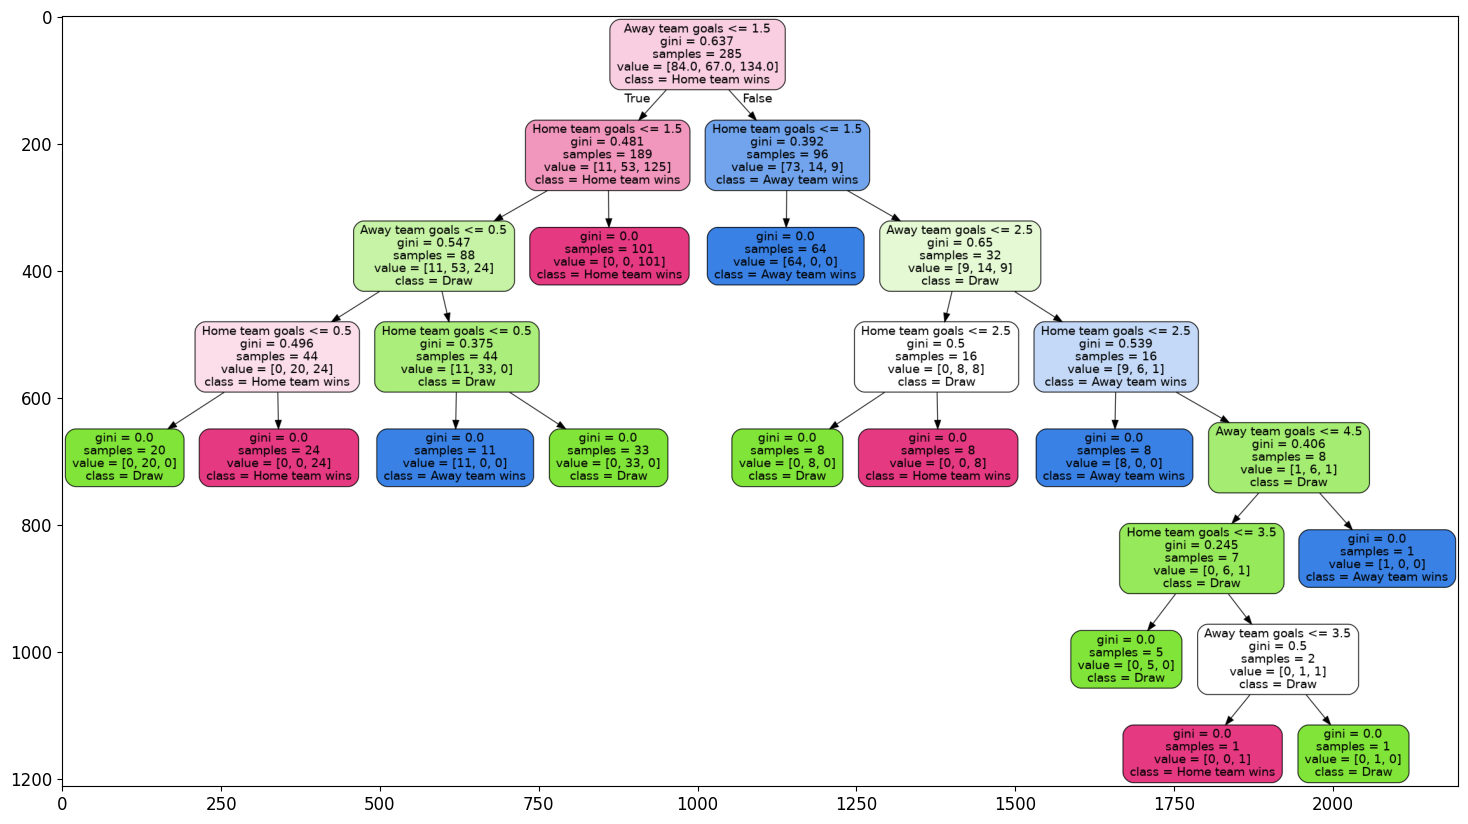

In [18]:
tree.export_graphviz(
dt,
out_file="futbol.dot",
feature_names=["Home team goals","Away team goals"],
class_names=["Away team wins","Draw","Home team wins"],
rounded=True,
filled=True
)

#dot to png
if 'google.colab' in sys.modules:
    !apt-get install graphviz

! dot -Tpng futbol.dot -o futbol.png

#Plot the image
img = cv2.imread('futbol.png')
plt.figure(figsize = (20, 10))
plt.imshow(img)

The DT can only do cuts in the individual features. Thus, it looks at home and away goals separately. But we know that in futbol the only important thing is to score more than the other team. The fact that it can only perform cuts on individual features can be a problem for DTs (but also the reason why we do not need to preprocess the features to remove units).

We can do some feature engineering

In [19]:
features_train=df_copy_train[['FTHG','FTAG']]
features_train['Local - Visitante'] = features_train['FTHG']-features_train['FTAG']
features_train=np.asarray(features_train)

features_test=df_copy_test[['FTHG','FTAG']]
features_test['Local - Visitante'] = features_test['FTHG']-features_test['FTAG']
features_test=np.asarray(features_test)

/tmp/ipykernel_83477/3998940832.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train['Local - Visitante'] = features_train['FTHG']-features_train['FTAG']
/tmp/ipykernel_83477/3998940832.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_test['Local - Visitante'] = features_test['FTHG']-features_test['FTAG']


In [20]:
dt = DecisionTreeClassifier()
dt.fit(features_train,target_train)

DecisionTreeClassifier()

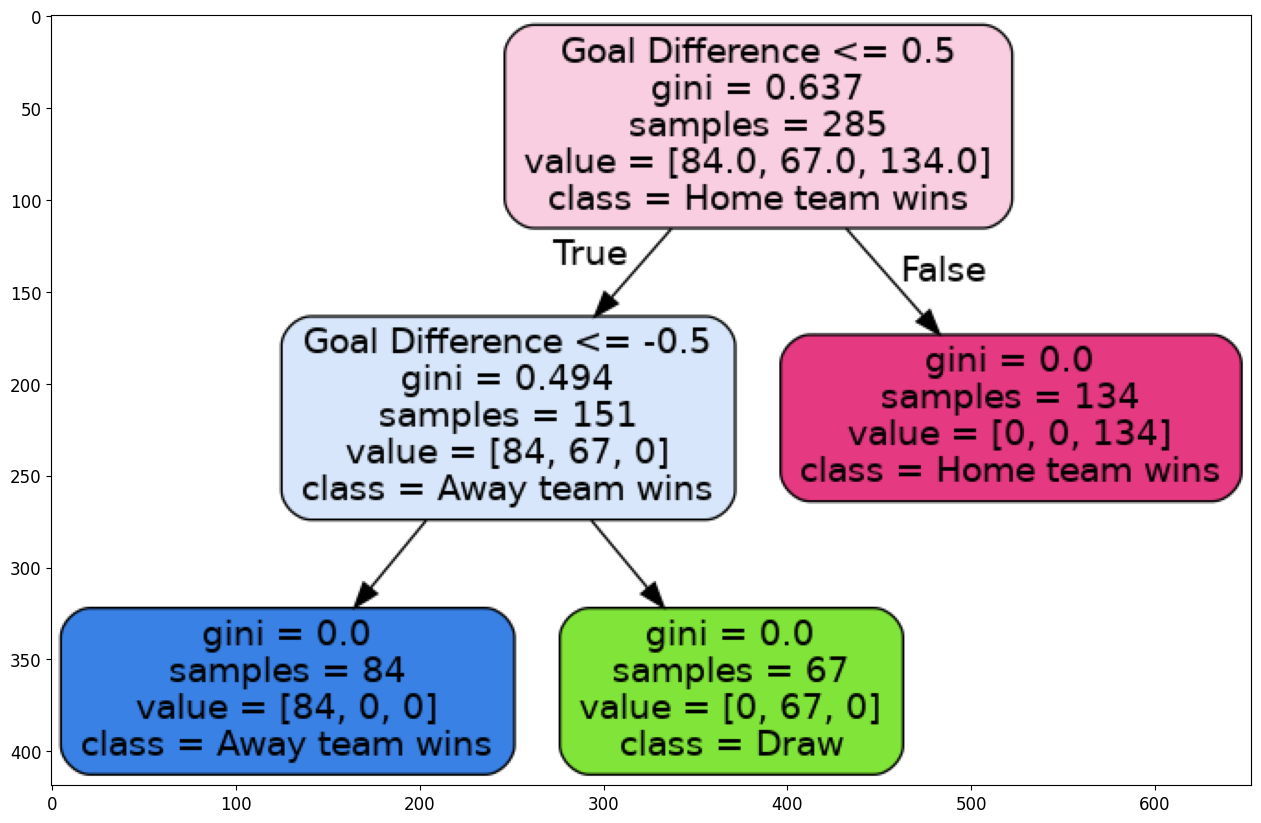

In [21]:
tree.export_graphviz(
dt,
out_file="futbol.dot",
feature_names=["Home","Away","Goal Difference"],
class_names=["Away team wins","Draw","Home team wins"],
rounded=True,
filled=True
)

#Convierto el dot a png
! dot -Tpng futbol.dot -o futbol.png

#Ploteamos el png
img = cv2.imread('futbol.png')
plt.figure(figsize = (20, 10))
plt.imshow(img)

Much better!

For such an easy example, DTs are not particularly useful. But now let's look at all the features that are less obvious in relation to wins. Let's remove the betting scores also.

In [22]:
names_train=df_copy_train[['HomeTeam','AwayTeam']]
features_train=df_copy_train.drop(['Div','Date','Referee','HomeTeam','AwayTeam','FTHG','FTAG','FTR','HTHG', 'HTAG', 'HTR', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD',
       'BWA', 'GBH', 'GBD', 'GBA', 'IWH', 'IWD', 'IWA', 'LBH', 'LBD', 'LBA',
       'SBH', 'SBD', 'SBA', 'WHH', 'WHD', 'WHA', 'SJH', 'SJD', 'SJA', 'VCH',
       'VCD', 'VCA', 'BSH', 'BSD', 'BSA', 'Bb1X2', 'BbMxH', 'BbAvH', 'BbMxD',
       'BbAvD', 'BbMxA', 'BbAvA', 'BbOU', 'BbMx>2.5', 'BbAv>2.5', 'BbMx<2.5',
       'BbAv<2.5', 'BbAH', 'BbAHh', 'BbMxAHH', 'BbAvAHH', 'BbMxAHA',
       'BbAvAHA'],axis=1)

names_test=df_copy_test[['HomeTeam','AwayTeam']]
features_test=df_copy_test.drop(['Div','Date','Referee','HomeTeam','AwayTeam','FTHG','FTAG','FTR','HTHG', 'HTAG', 'HTR', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD',
       'BWA', 'GBH', 'GBD', 'GBA', 'IWH', 'IWD', 'IWA', 'LBH', 'LBD', 'LBA',
       'SBH', 'SBD', 'SBA', 'WHH', 'WHD', 'WHA', 'SJH', 'SJD', 'SJA', 'VCH',
       'VCD', 'VCA', 'BSH', 'BSD', 'BSA', 'Bb1X2', 'BbMxH', 'BbAvH', 'BbMxD',
       'BbAvD', 'BbMxA', 'BbAvA', 'BbOU', 'BbMx>2.5', 'BbAv>2.5', 'BbMx<2.5',
       'BbAv<2.5', 'BbAH', 'BbAHh', 'BbMxAHH', 'BbAvAHH', 'BbMxAHA',
       'BbAvAHA'],axis=1)

In [23]:
features_train

HS  AS  HST  AST  HF  AF  HC  AC  HY  AY  HR  AR
133  14  15    4   10   7   9   3   5   0   3   0   0
230  20   3   11    3   9  14  11   1   2   3   0   1
94   20   8   12    3   9  14  10   2   3   4   0   1
22   17   7    9    4   5   7  12   6   0   2   0   0
152  17   3    6    0  11  11   9   1   1   1   0   0
..   ..  ..  ...  ...  ..  ..  ..  ..  ..  ..  ..  ..
75   13  14    9   11  16  14   5   4   4   4   0   0
322   8   9    4    6   7  18   6   5   1   1   0   0
236   2   8    1    4  12   8   4   3   2   0   0   0
251  20   2   13    2   6  10  10   3   0   2   0   0
229  10  12    6    4   6  14   3   6   1   1   0   0

[285 rows x 12 columns]

We took off the team names since we don't care about them in order to predict. The DT could use them if we turn them into a categorical variable.

Let's now look at the DT hyperparameters to regularize the algorithm. In particular, we can choose whether it uses Gini or Entropy to calculate the impurity of a split. Generally, there is no difference, but by definition, Gini may favor the most frequent class more. The advantage is that it is faster.

Looking at the other hyperparameters, the options we have in `sklearn` are:

`max_depth`: By default, this is `None`; it controls the depth of the tree.
`min_samples_split`: Sets the minimum number of samples a node must have to continue splitting it.
`min_samples_leaf`: The minimum number of samples a leaf (i.e., the end node) must have.
`min_weight_fraction_leaf`: The minimum weighted fraction of samples a leaf must have.
`max_leaf_nodes`: Maximum number of leaves.
`max_features`: Maximum number of features evaluated in a split.

If you raise the minimum values ​​or lower the maximum values, you are restricting the tree and regularizing the model.

There are other regularization methods, such as pruning, in which you train without restrictions and then remove unnecessary nodes.

In [24]:
dt=DecisionTreeClassifier()
#dt?

Let's play:

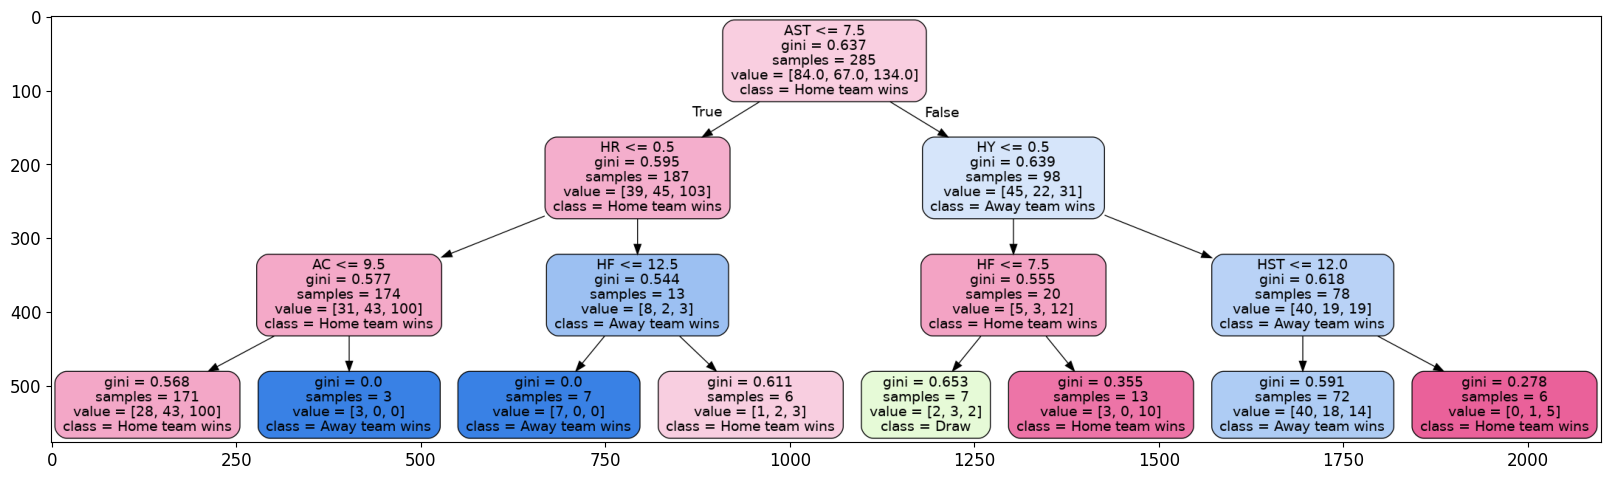

In [25]:
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(features_train,target_train)
tree.export_graphviz(
dt,
out_file="futbol.dot",
feature_names=features_train.columns,
class_names=["Away team wins","Draw","Home team wins"],
rounded=True,
filled=True
)

#Convierto el dot a png
! dot -Tpng futbol.dot -o futbol.png

#Ploteamos el png
img = cv2.imread('futbol.png')
plt.figure(figsize = (20, 10))
plt.imshow(img)

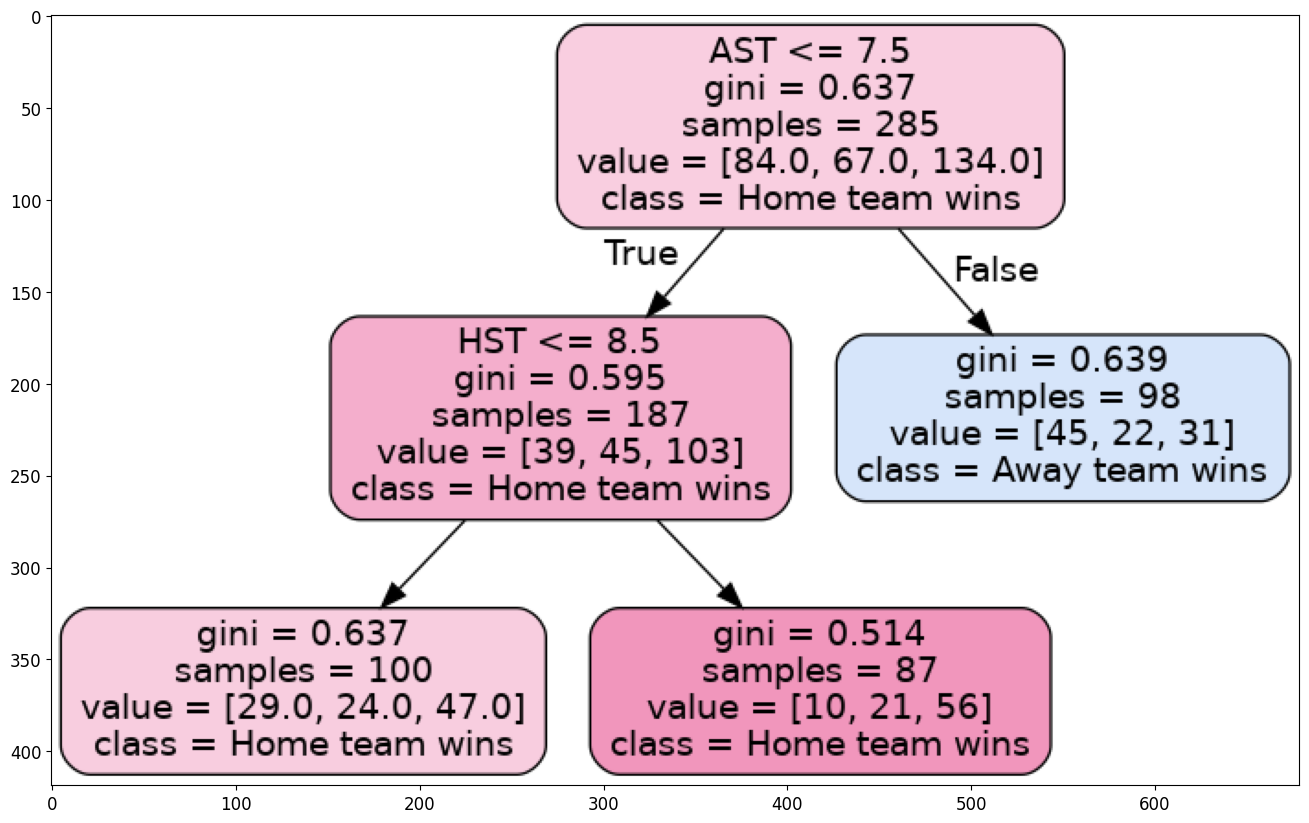

In [26]:
dt = DecisionTreeClassifier(min_samples_leaf=50,max_depth=100)
dt.fit(features_train,target_train)
tree.export_graphviz(
dt,
out_file="futbol.dot",
feature_names=features_train.columns,
class_names=["Away team wins","Draw","Home team wins"],
rounded=True,
filled=True
)

#Convierto el dot a png
! dot -Tpng futbol.dot -o futbol.png

#Ploteamos el png
img = cv2.imread('futbol.png')
plt.figure(figsize = (20, 10))
plt.imshow(img)

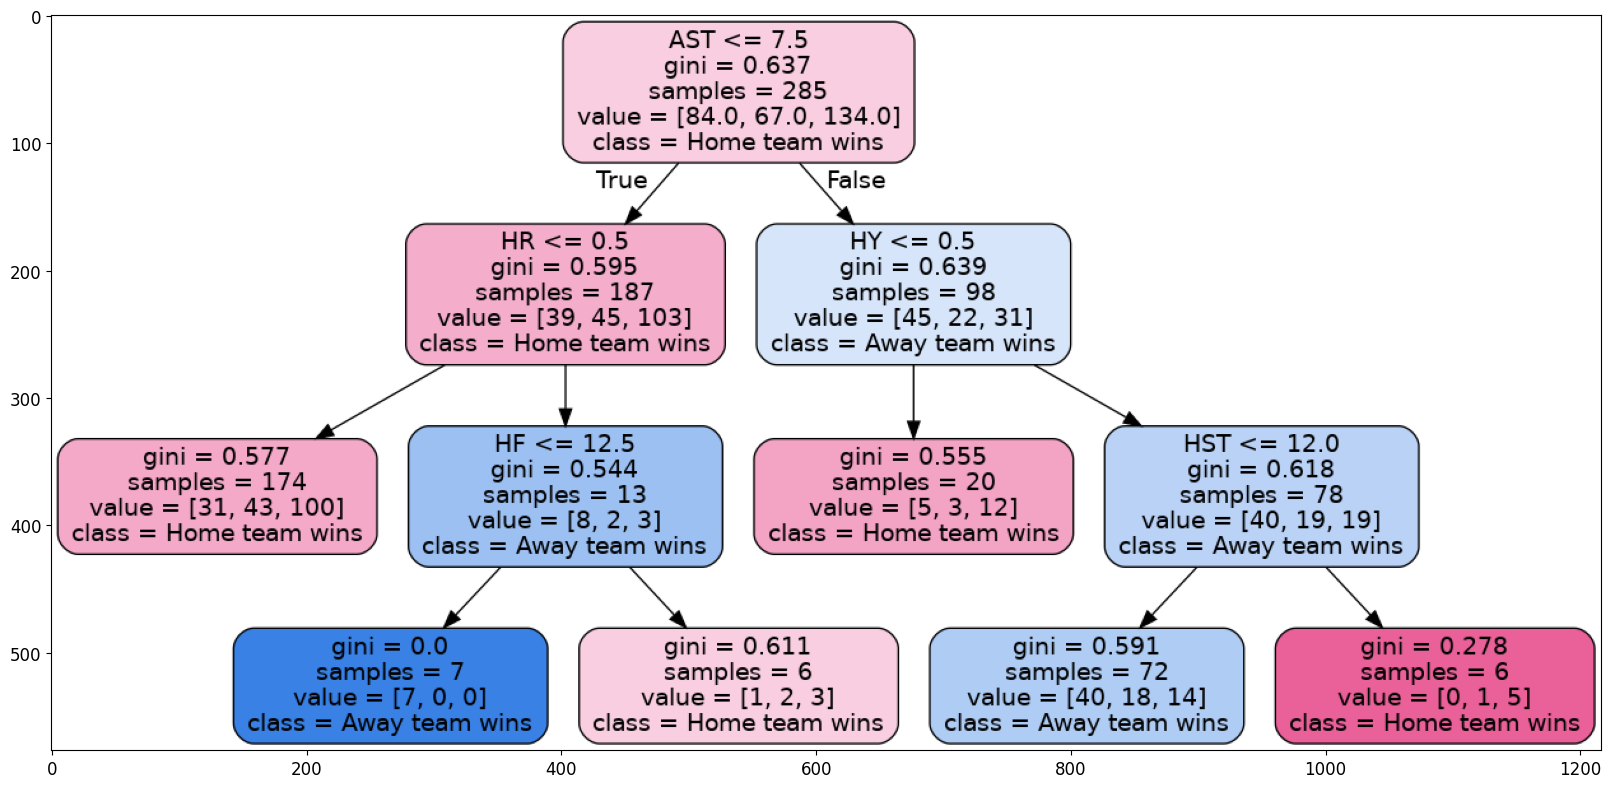

In [27]:
dt = DecisionTreeClassifier(max_leaf_nodes=6)
dt.fit(features_train,target_train)
tree.export_graphviz(
dt,
out_file="futbol.dot",
feature_names=features_train.columns,
class_names=["Away team wins","Draw","Home team wins"],
rounded=True,
filled=True
)

#Convierto el dot a png
! dot -Tpng futbol.dot -o futbol.png

#Ploteamos el png
img = cv2.imread('futbol.png')
plt.figure(figsize = (20, 10))
plt.imshow(img)

Now let's really optimize things

In [28]:
dt = DecisionTreeClassifier()
params={'max_depth':[2, 3, 5],'min_samples_leaf':[10,50], 'max_leaf_nodes':[3,4,5]}
grid=GridSearchCV(dt,params,cv=10,scoring='accuracy')
grid.fit(features_train,target_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 3, 5], 'max_leaf_nodes': [3, 4, 5],
                         'min_samples_leaf': [10, 50]},
             scoring='accuracy')

In [29]:
grid.best_params_

{'max_depth': 3, 'max_leaf_nodes': 4, 'min_samples_leaf': 10}

In [30]:
model=grid.best_estimator_

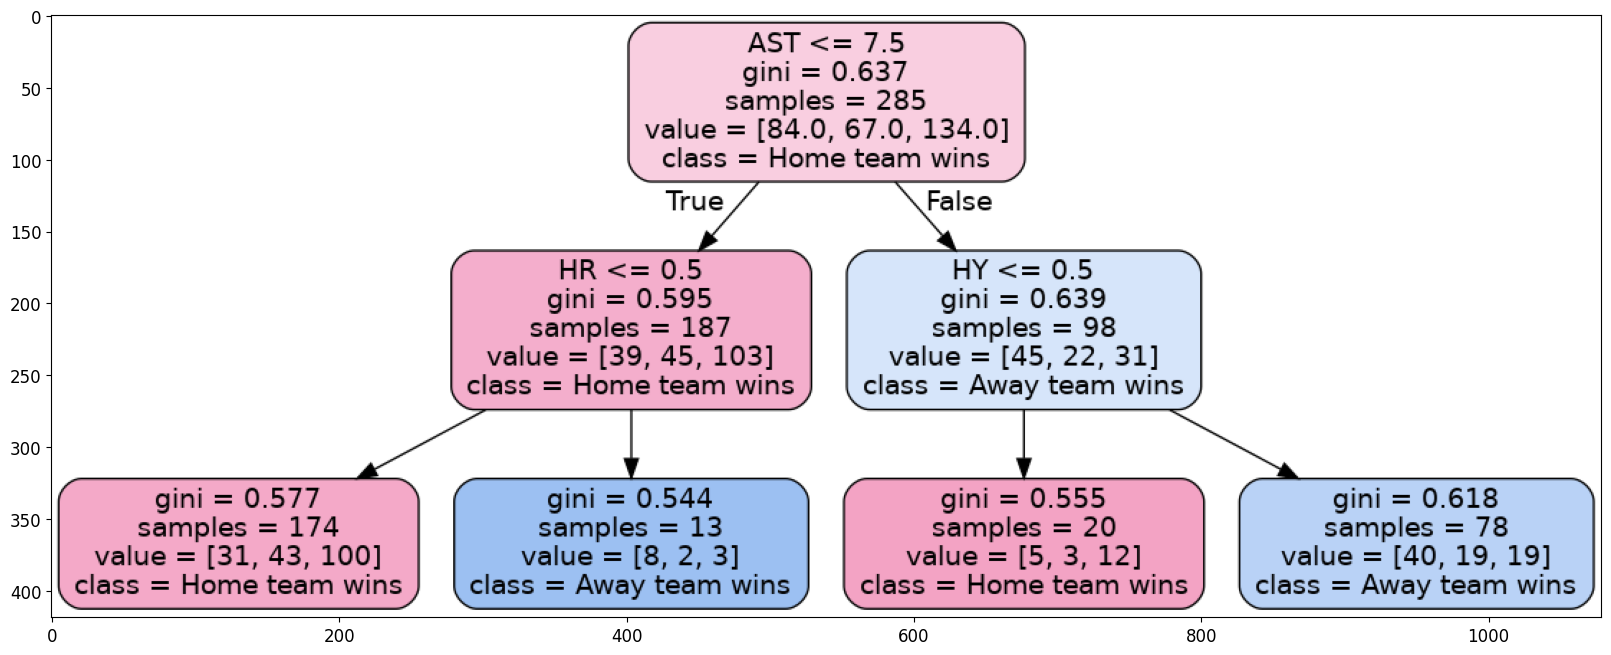

In [31]:
tree.export_graphviz(
model,
out_file="futbol.dot",
feature_names=features_train.columns,
class_names=["Away team wins","Draw","Home team wins"],
rounded=True,
filled=True
)

#Convierto el dot a png
! dot -Tpng futbol.dot -o futbol.png

#Ploteamos el png
img = cv2.imread('futbol.png')
plt.figure(figsize = (20, 10))
plt.imshow(img)

In [32]:

predicts = cross_val_predict(model,features_train,target_train,cv=5)
print(confusion_matrix(target_train,predicts))
print(recall_score(np.where(target_train==-1.0,1.0,0.0),np.where(predicts==-1.0,1.0,0.0)))
print(recall_score(np.where(target_train==0.0,1.0,0.0),np.where(predicts==0.0,1.0,0.0)))
print(recall_score(np.where(target_train==1.0,1.0,0.0),np.where(predicts==1.0,1.0,0.0)))

print(accuracy_score(np.where(target_train==-1.0,1.0,0.0),np.where(predicts==-1.0,1.0,0.0)))
print(accuracy_score(np.where(target_train==0.0,1.0,0.0),np.where(predicts==0.0,1.0,0.0)))
print(accuracy_score(np.where(target_train==1.0,1.0,0.0),np.where(predicts==1.0,1.0,0.0)))

print(confusion_matrix(target_test,model.predict(features_test)))

[[ 40   0  44]
 [ 18   0  49]
 [ 27   0 107]]
0.47619047619047616
0.0
0.7985074626865671
0.6877192982456141
0.7649122807017544
0.5789473684210527
[[19  0 13]
 [ 9  0 17]
 [ 9  0 28]]


In [33]:
print(model.predict_proba(features_train[:3]))
print(np.argmax(model.predict_proba(features_train[:3]),axis=1)-1)
print(model.predict(features_train[:3]))

[[0.25       0.15       0.6       ]
 [0.17816092 0.24712644 0.57471264]
 [0.17816092 0.24712644 0.57471264]]
[1 1 1]
[1. 1. 1.]


In [34]:
print(np.where(model.predict(features_train[:3])==-1.0,1.0,0.0))
print(np.where(model.predict(features_train[:3])==0.0,1.0,0.0))
print(np.where(model.predict(features_train[:3])==1.0,1.0,0.0))

[0. 0. 0.]
[0. 0. 0.]
[1. 1. 1.]


In [35]:
thresholds=[0.2, 0.4,0.6, 0.8]
for threshold in thresholds:
  print("Threshold "+str(threshold)+'\n')
  y_pred_away=np.where(model.predict_proba(features_train)[:,0]>=threshold,1.0,0.0)
  y_pred_draw=np.where(model.predict_proba(features_train)[:,1]>=threshold,1.0,0.0)
  y_pred_home=np.where(model.predict_proba(features_train)[:,2]>=threshold,1.0,0.0)
  print(accuracy_score(np.where(target_train==-1.0,1.0,0.0),y_pred_away))
  print(accuracy_score(np.where(target_train==0.0,1.0,0.0),y_pred_draw))
  print(accuracy_score(np.where(target_train==1.0,1.0,0.0),y_pred_home))
  print("\n")

Threshold 0.2

0.6877192982456141
0.3157894736842105
0.47017543859649125


Threshold 0.4

0.7228070175438597
0.7649122807017544
0.6350877192982456


Threshold 0.6

0.7157894736842105
0.7649122807017544
0.543859649122807


Threshold 0.8

0.7052631578947368
0.7649122807017544
0.5298245614035088




In [36]:
print(recall_score(np.where(target_train==-1.0,1.0,0.0),np.where(np.argmax(model.predict_proba(features_train),axis=1)==0,1.0,0.0)))
print(recall_score(np.where(target_train==0.0,1.0,0.0),np.where(np.argmax(model.predict_proba(features_train),axis=1)==1,1.0,0.0)))
print(recall_score(np.where(target_train==1.0,1.0,0.0),np.where(np.argmax(model.predict_proba(features_train),axis=1)==2,1.0,0.0)))

0.5714285714285714
0.0
0.835820895522388


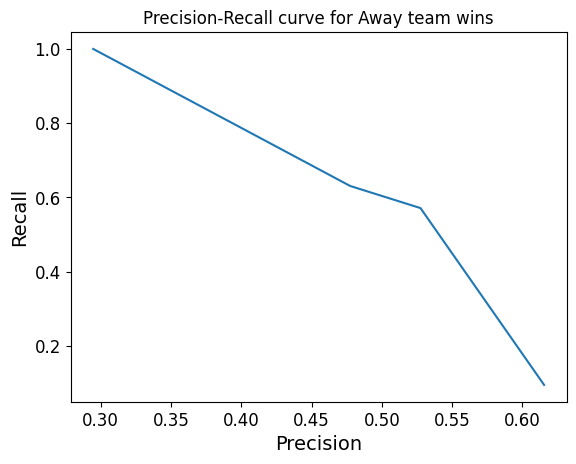

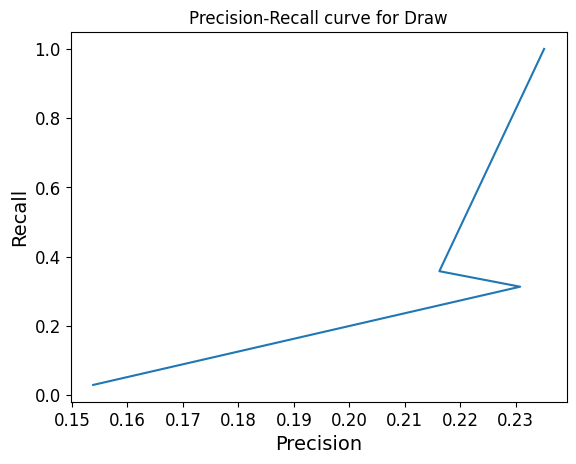

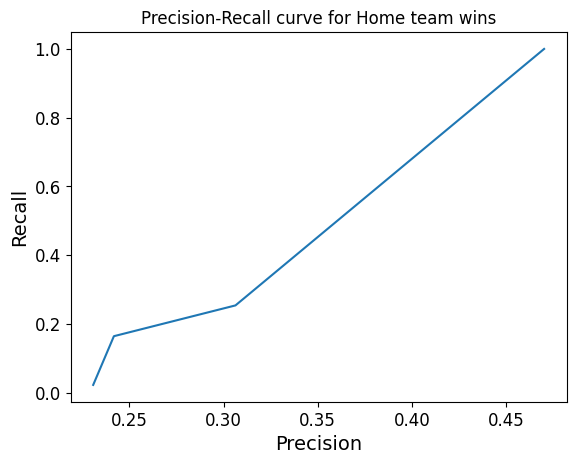

In [37]:
from sklearn.metrics import precision_recall_curve
class_names=['Away team wins', 'Draw', 'Home team wins']
for nclass_label, class_label in enumerate([-1.0,0.0,1.0]):
  precision, recall, thresholds = precision_recall_curve(target_train,model.predict_proba(features_train)[:,0],pos_label=class_label)
  plt.plot(precision[:-1],recall[:-1])
  plt.title('Precision-Recall curve for '+str(class_names[nclass_label]))
  plt.xlabel('Precision')
  plt.ylabel('Recall')
  # plt.xlim(0.0,1.0)
  # plt.ylim(0.0,1.0)
  plt.show()

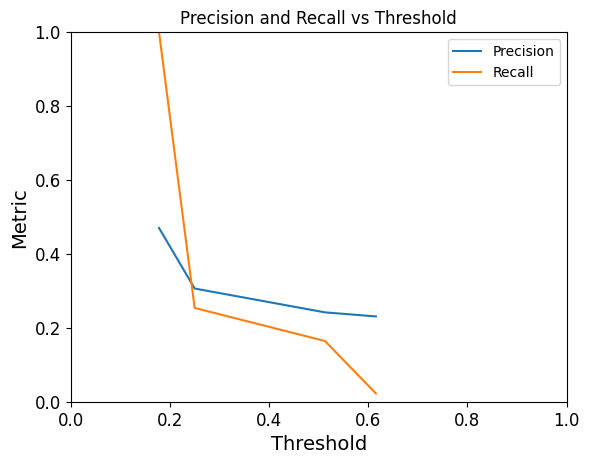

In [38]:
plt.plot(thresholds,precision[:-1],label='Precision')
plt.plot(thresholds,recall[:-1],label='Recall')
plt.title('Precision and Recall vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Metric')
plt.legend()
plt.xlim(0.0,1.0)
plt.ylim(0.0,1.0)
plt.show()

It's hard to predict draws!

## Exercise:

Add bets as features and optimize the DT. What do you find? Can you assess feature importance? In particular, is it more important to see at "in-game" info or "pre-game" bets?

In [39]:
###START_EXERCISE
# You can add your solution in this code cell.
###STOP_EXERCISE

In [40]:
###START_SOLUTION
###STOP_SOLUTION

## Regression

Let's see how DTs can be used for regression with a synthetic dataset:

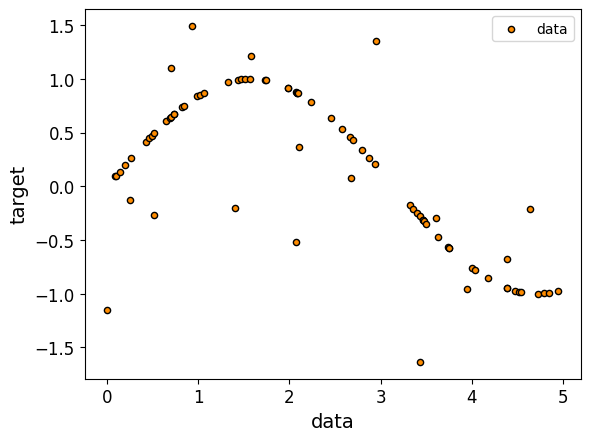

In [41]:
# Create a random dataset
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - rng.rand(16))

X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]


# Plot the results
plt.figure()
plt.scatter(X, y, s=20, edgecolor="black",
            c="darkorange", label="data")
plt.xlabel("data")
plt.ylabel("target")
#plt.title("Decision Tree Regression")
plt.legend()
plt.show()

We can see how DTs operate by exploring different depths:

In [42]:
# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5,min_samples_leaf=5)
regr_1.fit(X, y)
regr_2.fit(X, y)
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)

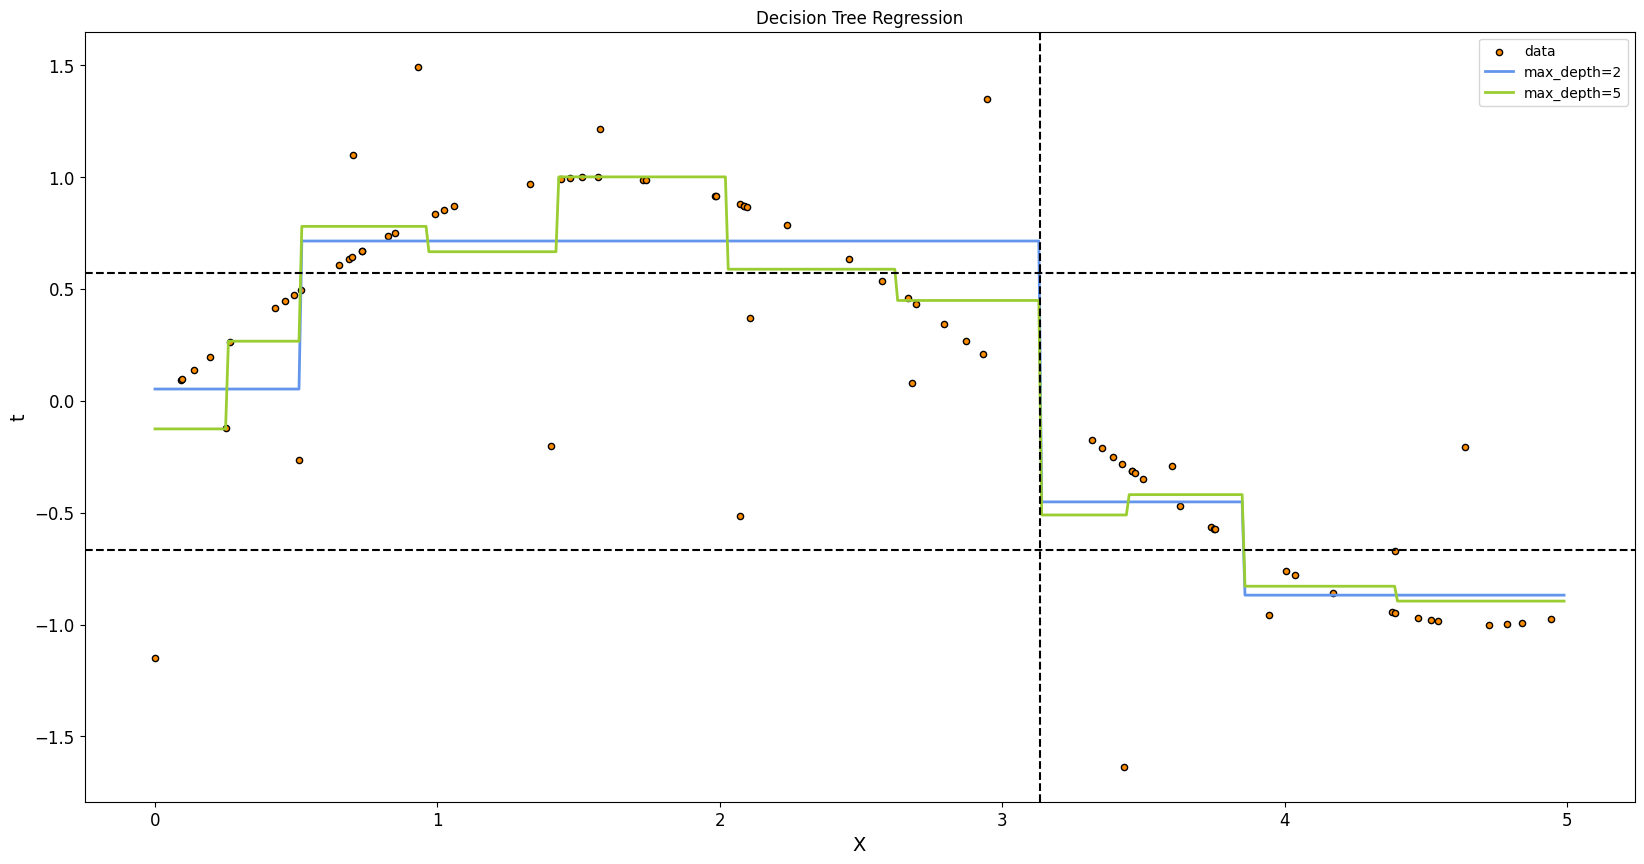

In [43]:
# Plot the results
plt.figure(figsize=(20,10))
plt.scatter(X, y, s=20, edgecolor="black",
            c="darkorange", label="data")
plt.plot(X_test, y_1, color="cornflowerblue",
         label="max_depth=2", linewidth=2)
plt.plot(X_test, y_2, color="yellowgreen", label="max_depth=5", linewidth=2)
plt.axvline(3.133,linestyle='dashed',color='black')
plt.axhline(0.571,linestyle='dashed',color='black')
plt.axhline(-0.667,linestyle='dashed',color='black')
plt.xlabel("X")
plt.ylabel("t")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

The tree decides on a predicted value by doing cuts in feature space. `max_depth` controls the number of cuts the algorithm makes. Let's see how the target is assigned:

In [44]:
np.mean(y)

0.12215899268094885

In [45]:
mean_squared_error(np.mean(y)*np.ones(len(y)),y)

0.5471130002937142

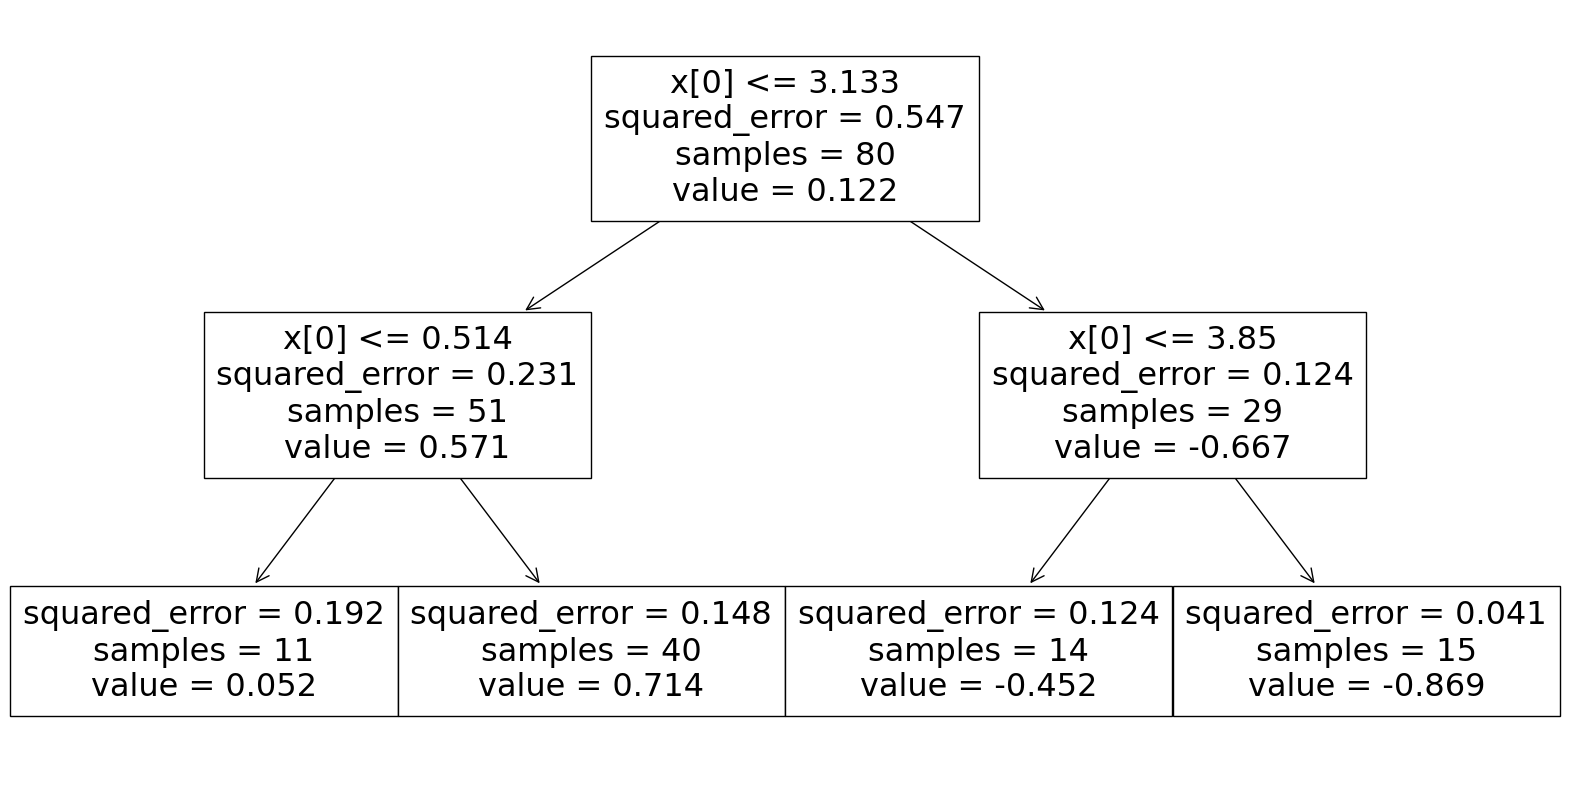

In [46]:
plt.figure(figsize=(20,10))
tree.plot_tree(regr_1) 
plt.show()

In [47]:
y_first_cut=y[(X[:,0]<=3.133)]
print(np.mean(y_first_cut),np.mean(y[(X[:,0]>3.133)]))
print(mean_squared_error(np.mean(y_first_cut)*np.ones(len(y_first_cut)),y_first_cut))

0.5711567593351029 -0.6674577693660114
0.23136965662280937


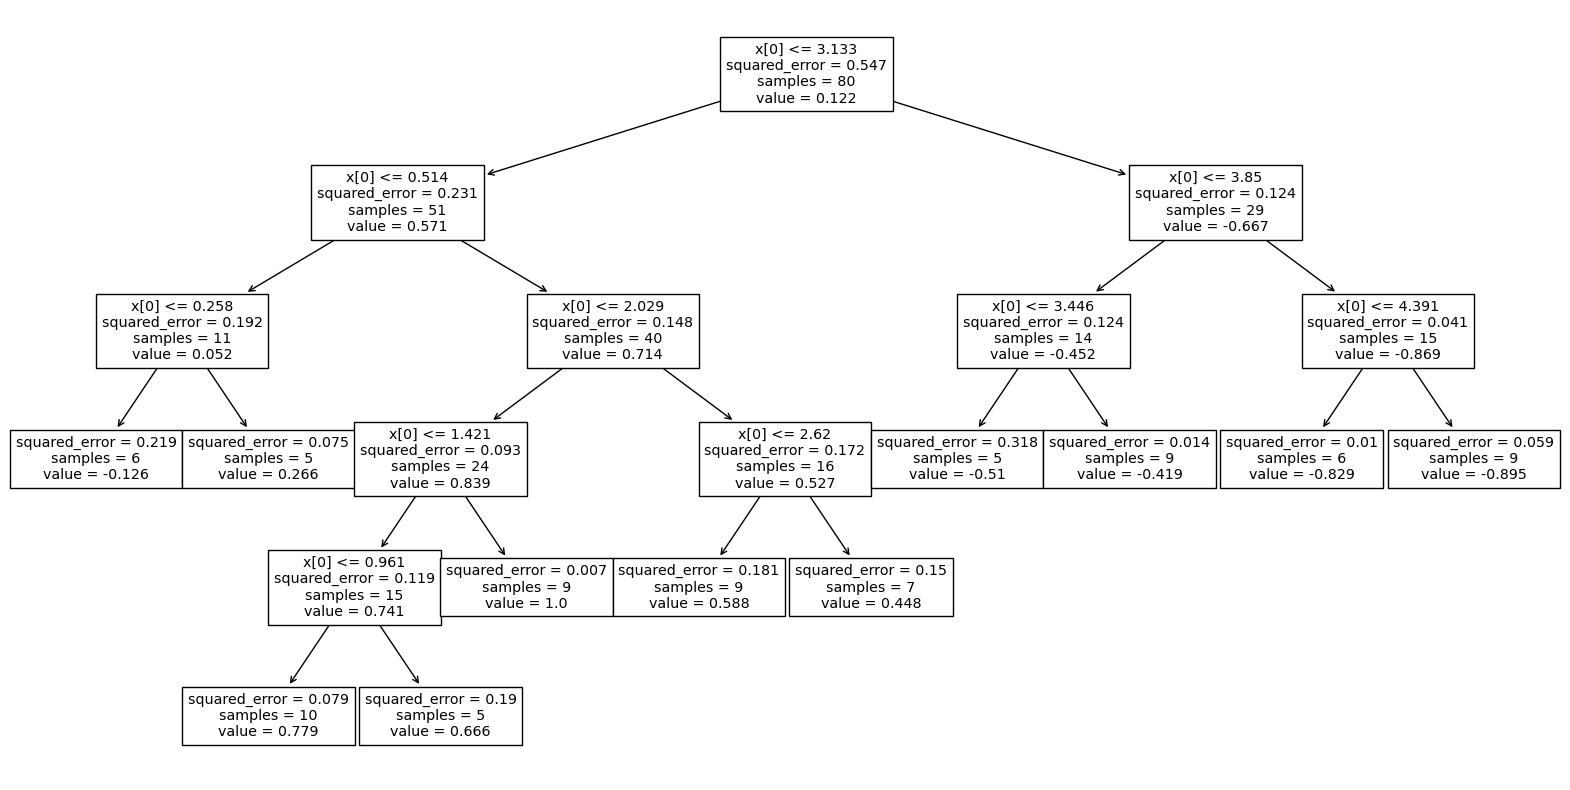

In [48]:
plt.figure(figsize=(20,10))
tree.plot_tree(regr_2) 
plt.show()

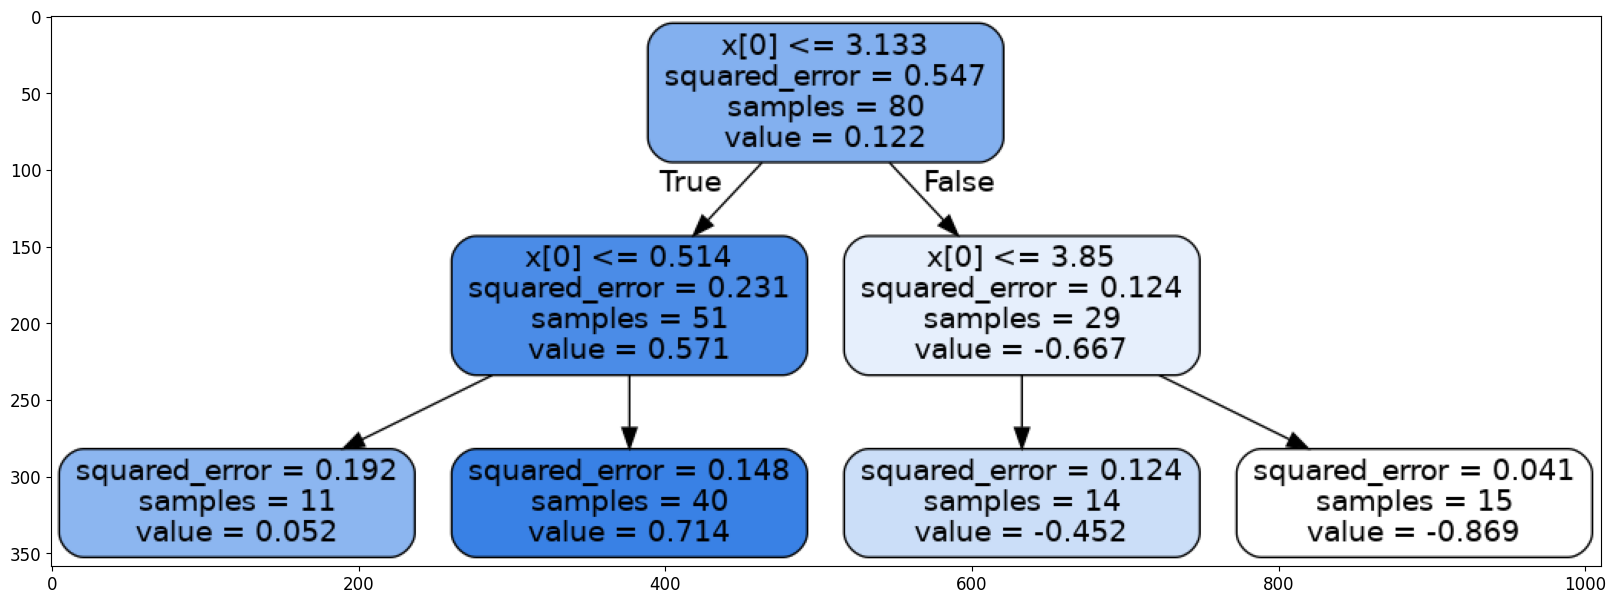

In [49]:
tree.export_graphviz(
regr_1,
out_file="reg_tree.dot",
rounded=True,
filled=True
)

#Convierto el dot a png
! dot -Tpng reg_tree.dot -o reg_tree.png

#Ploteamos el png
img = cv2.imread('reg_tree.png')
plt.figure(figsize = (20, 10))
plt.imshow(img)

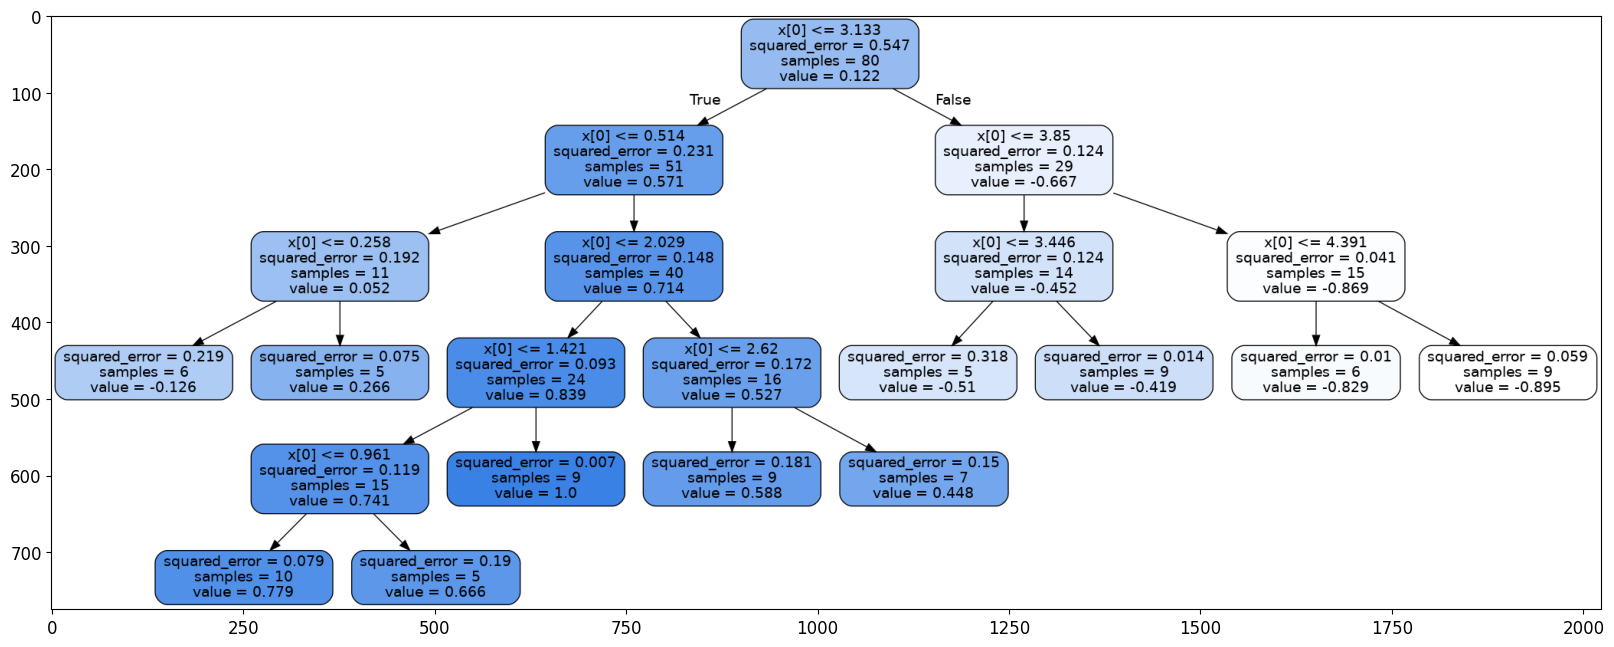

In [50]:
tree.export_graphviz(
regr_2,
out_file="reg_tree.dot",
rounded=True,
filled=True
)

#Convierto el dot a png
! dot -Tpng reg_tree.dot -o reg_tree.png

#Ploteamos el png
img = cv2.imread('reg_tree.png')
plt.figure(figsize = (20, 20))
plt.imshow(img)

To select the cut, it does not consider neither Gini nor entropy, it uses the MSE! Additionally, it assigns as predicted target the mean of all features before the cut is made.

## Exercise:

Let's consider the California dataset. Train a DT to predict the house price. Optimize the hyperparameter and report the RMSE and a predicted vs actual house value.

In [51]:
HOUSING_PATH = "datasets"
import pandas as pd
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [52]:
### from Geron

if 'google.colab' in sys.modules:
        
    import tarfile

    DOWNLOAD_ROOT = "https://github.com/ageron/handson-ml2/raw/master/"
    HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

    !mkdir -p ./datasets/housing

    def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
        os.makedirs(housing_path, exist_ok=True)
        tgz_path = os.path.join(housing_path, "housing.tgz")
        #urllib.request.urlretrieve(housing_url, tgz_path)
        !wget {HOUSING_URL} -P {housing_path}
        housing_tgz = tarfile.open(tgz_path)
        housing_tgz.extractall(path=housing_path)
        housing_tgz.close()

    # Corramos la función
    fetch_housing_data()

else: 
    print("Not running on Google Colab. This cell is did not do anything.")

Not running on Google Colab. This cell is did not do anything.


In [53]:
housing_pre = load_housing_data()
from sklearn.model_selection import StratifiedShuffleSplit

housing_pre["income_cat"] = pd.cut(housing_pre["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=445543)
for train_index, test_index in split.split(housing_pre, housing_pre["income_cat"]):
    california_housing_train = housing_pre.loc[train_index]
    california_housing_test = housing_pre.loc[test_index]

for set_ in (california_housing_train, california_housing_test):
    set_.drop("income_cat", axis=1, inplace=True)

In [54]:
housing=california_housing_train.copy()

problematic_columns = ['median_house_value', 'housing_median_age', 'median_income']
max_values=[]
for col in problematic_columns:
    max_value = housing[col].max()
    print(f"{col}: {sum(housing[col] == max_value)} districts with {col} = {max_value} ({round(sum(housing[col] == max_value)/len(housing)*100,2)}%).")
    max_values.append(max_value)

housing_clean = housing.copy()
for col, max_value in zip(problematic_columns, max_values):
    housing_clean = housing_clean[housing_clean[col] != max_value]

housing_test=california_housing_test.copy()
housing_test_clean = housing_test.copy()
for col, max_value in zip(problematic_columns, max_values):
    housing_test_clean = housing_test_clean[housing_test_clean[col] != max_value]

median_house_value: 762 districts with median_house_value = 500001.0 (4.61%).
housing_median_age: 997 districts with housing_median_age = 52.0 (6.04%).
median_income: 42 districts with median_income = 15.0001 (0.25%).


In [55]:
housing_clean["rooms_per_household"] = housing_clean["total_rooms"]/housing_clean["households"]
housing_clean["bedrooms_per_room"] = housing_clean["total_bedrooms"]/housing_clean["total_rooms"]
housing_clean["population_per_household"]=housing_clean["population"]/housing_clean["households"]

housing_test_clean["rooms_per_household"] = housing_test_clean["total_rooms"]/housing_test_clean["households"]
housing_test_clean["bedrooms_per_room"] = housing_test_clean["total_bedrooms"]/housing_test_clean["total_rooms"]
housing_test_clean["population_per_household"]=housing_test_clean["population"]/housing_test_clean["households"]

In [56]:
housing_labels = housing_clean["median_house_value"].copy()
housing_clean = housing_clean.drop("median_house_value", axis=1) # drop labels for training set
housing_num = housing_clean.drop("ocean_proximity", axis=1)

housing_test_labels = housing_test_clean["median_house_value"].copy()
housing_test_clean = housing_test_clean.drop("median_house_value", axis=1) # drop labels for training set
housing_test_num = housing_test_clean.drop("ocean_proximity", axis=1)

Some useful preprocessing

In [57]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),#hay mas opciones aca
        ('std_scaler', StandardScaler()),
    ])

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing_clean)
housing_test_prepared=full_pipeline.transform(housing_test_clean)

In [58]:
###START_EXERCISE
# You can add your solution in this code cell.
###STOP_EXERCISE

In [59]:
###START_SOLUTION
###STOP_SOLUTION

## Another nice example

This is verbatim from `sklearn` documentation:

In [60]:
from sklearn.datasets import fetch_olivetti_faces
from sklearn.utils.validation import check_random_state

# Load the faces datasets
data, targets = fetch_olivetti_faces(return_X_y=True)

We can try to predict the lower half of a face using the upper half:

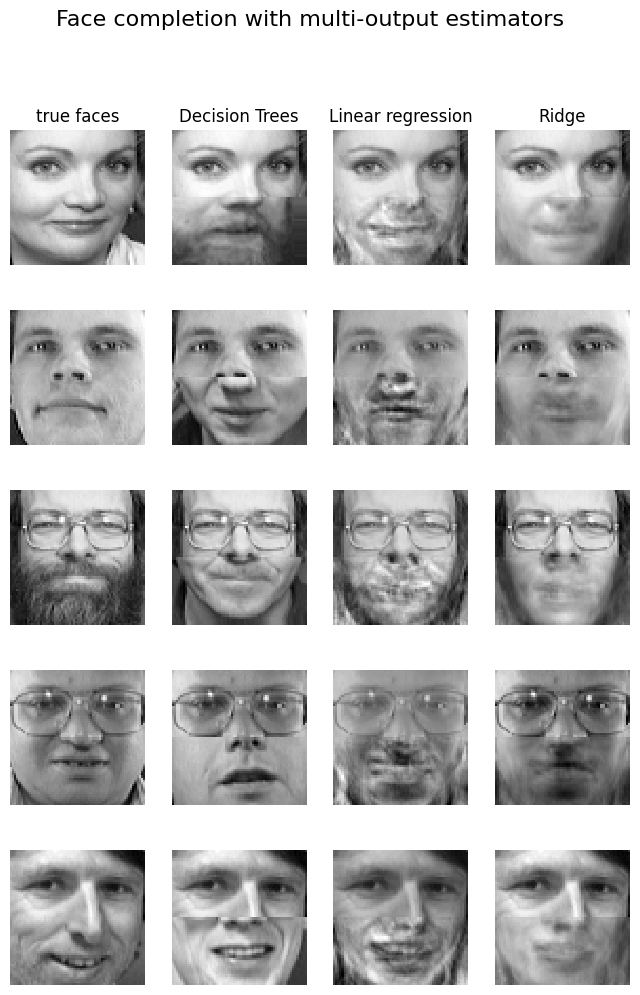

In [61]:
train = data[targets < 30]
test = data[targets >= 30]  # Test on independent people

# Test on a subset of people
n_faces = 5
rng = check_random_state(4)
face_ids = rng.randint(test.shape[0], size=(n_faces, ))
test = test[face_ids, :]

n_pixels = data.shape[1]
# Upper half of the faces
X_train = train[:, :(n_pixels + 1) // 2]
# Lower half of the faces
y_train = train[:, n_pixels // 2:]
X_test = test[:, :(n_pixels + 1) // 2]
y_test = test[:, n_pixels // 2:]

# Fit estimators
ESTIMATORS = {
    "Decision Trees": DecisionTreeRegressor(),
    "Linear regression": LinearRegression(),
    "Ridge": RidgeCV(),
}

y_test_predict = dict()
for name, estimator in ESTIMATORS.items():
    estimator.fit(X_train, y_train)
    y_test_predict[name] = estimator.predict(X_test)

# Plot the completed faces
image_shape = (64, 64)

n_cols = 1 + len(ESTIMATORS)
plt.figure(figsize=(2. * n_cols, 2.26 * n_faces))
plt.suptitle("Face completion with multi-output estimators", size=16)

for i in range(n_faces):
    true_face = np.hstack((X_test[i], y_test[i]))

    if i:
        sub = plt.subplot(n_faces, n_cols, i * n_cols + 1)
    else:
        sub = plt.subplot(n_faces, n_cols, i * n_cols + 1,
                          title="true faces")

    sub.axis("off")
    sub.imshow(true_face.reshape(image_shape),
               cmap=plt.cm.gray,
               interpolation="nearest")

    for j, est in enumerate(sorted(ESTIMATORS)):
        completed_face = np.hstack((X_test[i], y_test_predict[est][i]))

        if i:
            sub = plt.subplot(n_faces, n_cols, i * n_cols + 2 + j)

        else:
            sub = plt.subplot(n_faces, n_cols, i * n_cols + 2 + j,
                              title=est)

        sub.axis("off")
        sub.imshow(completed_face.reshape(image_shape),
                   cmap=plt.cm.gray,
                   interpolation="nearest")

plt.show()

## Bagging and Random Forests

Bagging is a particular type of **ensemble** training. Ensemble methods combine different estimators to build a better one, usually reducing the variance and overfitting. In bagging, which originates from **bootstrapping agreggating**, we bootstrap the data and train a model for each bootstrapped dataset. The overall model is then an average of the trained predictors.

A **RandomForest** is a bagging model where the base estimator is a Decision Tree and where additionally **feature bagging** is performed. That is, at each decision step for each bootstrapped dataset, only a subset of features chosen at random is considered to select the optimal cut. This further increases the variability of the ensembled models. The added stochasticity can make the decision frontier more irregular, but usually increases performance.

Let's see this using an example.

In [62]:
# Let us define a couple of useful functions (if in colab, otherwise, take from utils module)

### From Rodrigo Diaz

def plot_clasi(x, t, ws, labels=[], xp=[-1., 1.], thr=[0,], spines='zero', equal=True, 
                join_centers=False, margin=None):
    """
    Figura con el resultado del ajuste lineal
    """
    assert len(labels) == len(ws) or len(labels) == 0
    assert len(ws) == len(thr)

    if margin is None:
        margin = [False] * len(ws)
    else:    
        margin = np.atleast_1d(margin)
    assert len(margin) == len(ws)

    if len(labels) == 0:
        labels = np.arange(len(ws)).astype('str')

    # Agregemos el vector al plot
    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111)

    xc1 = x[t == np.unique(t).max()]
    xc2 = x[t == np.unique(t).min()]

    ax.plot(*xc1.T, 'ob', mfc='None', label='C1')
    ax.plot(*xc2.T, 'or', mfc='None', label='C2')

    for i, w in enumerate(ws):

        # Compute vector norm
        wnorm = np.sqrt(np.sum(w**2))

        # Ploteo vector de pesos
        x0 = 0.5 * (xp[0] + xp[1])
        ax.quiver(0, thr[i]/w[1], w[0]/wnorm, w[1]/wnorm, 
                    color='C{}'.format(i+2), scale=10, label=labels[i], 
                    zorder=10)

        # ploteo plano perpendicular
        xp = np.array(xp)
        yp = (thr[i] - w[0]*xp)/w[1] 

        plt.plot(xp, yp, '-', color='C{}'.format(i+2))

        # Plot margin
        if margin[i]:
            for marg in [-1, 1]:
                ym = yp + marg/w[1]
                plt.plot(xp, ym, ':', color='C{}'.format(i+2))


    if join_centers:
        # Ploteo línea que une centros de los conjuntos
        mu1 = xc1.mean(axis=1)
        mu2 = xc2.mean(axis=1)
        ax.plot([mu1[0], mu2[0]], [mu1[1], mu2[1]], 'o:k', mfc='None', ms=10)    

    ax.legend(loc=0, fontsize=12)
    if equal:
        ax.set_aspect('equal')

    if spines is not None:
        for a in ['left', 'bottom']:
            ax.spines[a].set_position('zero')
        for a in ['top', 'right']:
            ax.spines[a].set_visible(False)

    return


def makew(fitter):

    # # Obtengamos los pesos y normalicemos
    w = fitter.coef_.copy()

    # # Incluye intercept
    if fitter.fit_intercept:
        w = np.hstack([fitter.intercept_.reshape(1,1), w])

    # # Normalizon
    #w /= np.linalg.norm(w)
    return w.T

#Utility from Geron
def plot_decision_regions(clf, X, t, axes=None, npointsgrid=500, legend=False, 
                          plot_training=True, 
                          figkwargs={'figsize': [12, 8]}, 
                          contourkwargs={'alpha':0.3}):
    """
    Plot decision regions produced by classifier.

    :param Classifier clf: sklearn classifier supporting XXX
    """

    fig = plt.figure(**figkwargs)
    ax = fig.add_subplot(111)

    if axes is None:
        dx = X[:, 0].max() - X[:, 0].min()
        dy = X[:, 1].max() - X[:, 1].min()
        axes = [X[:, 0].min() - 0.1*dx, X[:, 0].max() + 0.1*dx, 
                X[:, 1].min() - 0.1*dy, X[:, 1].max() + 0.1*dy]
        
    # Define grid for regions
    x1s = np.linspace(axes[0], axes[1], npointsgrid)
    x2s = np.linspace(axes[2], axes[3], npointsgrid)
    x1, x2 = np.meshgrid(x1s, x2s)

    # Make predictions on points of grid; reshape to grid format
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)

    #custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    ax.contourf(x1, x2, y_pred, **contourkwargs)

#     custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
#         plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)

    if plot_training:
        for label in np.unique(t):
            ax.plot(X[:, 0][t==label], X[:, 1][t==label], "o", label="C{}".format(label))

    # Axis
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

    if legend:
        plt.legend(loc="lower right", fontsize=14)

    plt.show()
    return fig
    
    


## Example with Moons dataset

Let's use a simple non-linearly separable dataset to exemplify this:

In [63]:
from sklearn.datasets import make_moons
X, t = make_moons(n_samples=400, noise=0.25, random_state=1234)

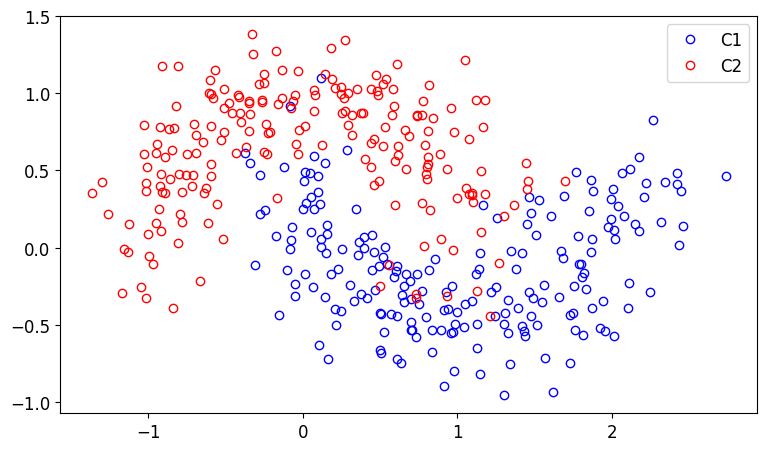

In [64]:
plot_clasi(X, t, [], [], [], [], spines=None)

In [65]:
# Split
X, X_test, t, t_test = train_test_split(X, t, test_size=0.2)

## Simple RF training

In [66]:
from sklearn.ensemble import RandomForestClassifier

In [67]:
rf = RandomForestClassifier(n_estimators=100, max_depth=2, n_jobs=6)
rf.fit(X, t)

RandomForestClassifier(max_depth=2, n_jobs=6)

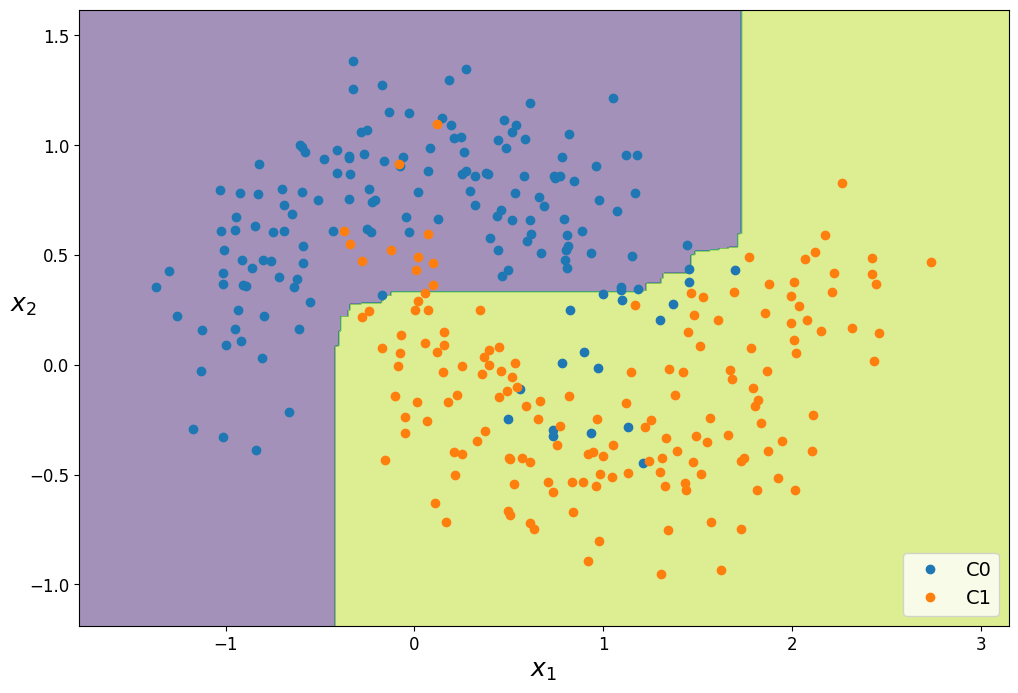

In [68]:
fig = plot_decision_regions(rf, X, t, legend=True, npointsgrid=500, 
                            figkwargs={'figsize': [12, 8]}, 
                            contourkwargs={'alpha':0.5, 'levels':5, 'cmap':'viridis'})

This will not generalize well...

In [69]:
from sklearn.metrics import accuracy_score

y_train = rf.predict(X)
y_test = rf.predict(X_test)
print('Accuracy (train): {:.3f}'.format(accuracy_score(t, y_train)))
print('Accuracy (test): {:.3f}'.format(accuracy_score(t_test, y_test)))

Accuracy (train): 0.912
Accuracy (test): 0.912


Below you can solve this by optimizing the Random Forest using `GridSearchCV`.

Another feature of RFs is their interpretability. Since it's based on a white box algorithm, Decision Trees, we can use to study the learned properties. In particular, we can gauge feature importance by inspecting the fitted DTs. For a given DT, the most important features are closer to the root. We can perform statistics on the feature importances by averaging over the fitted DTs.

`sklearn` stores this through `feature_importances_`

In [70]:
print(rf.feature_importances_)
for name, score in zip(["x_1", "x_2"], rf.feature_importances_):
    print(name, score)


[0.43039855 0.56960145]
x_1 0.4303985520017519
x_2 0.5696014479982481


## Exercise

Train an optimize Random Forest by exploring the possible hyperparameters. Compare with a simpler classifier like an optimized polynomial Logistic Regressor or a optimized Decision Tree.

In [71]:
###START_EXERCISE
# You can add your solution in this code cell.

param_grid = {'param1': ...,
              'param2': ...,
              ...
             }

gscv_rf = GridSearchCV(..., ..., ...)

###STOP_EXERCISE

SyntaxError: ':' expected after dictionary key (3271992567.py, line 6)

In [ ]:
###START_SOLUTION
###STOP_SOLUTION

## Boosted and Boosted Decision Trees

Boosting methods are another example of **ensemble** methods. They also combine different instances of a base estimator. However, in boosting each successive instance learns both from the data and from the previous estimator. That is, it learns to "correct" the previous estimator.

* It usually **greatly improves** the performance of **weak predictors**.
* It's not easily paralellizable.
* It's greedy. Each step seeks to be as good as possible without thinking of global strategies.


We'll see two types of boosting: AdaBoosting and GradientBoosting.

In [72]:
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor, GradientBoostingRegressor, GradientBoostingClassifier

## AdaBoost

In AdaBoost, at each step the data points are weighted according to the performance of the previous estimator (they are initiated to 1)

That is, for steps $i=1,\dots,N$
1. We train a predictor $h_i$.
2. We update the per sample weight $w_{n,i}=f(w_{n,i-1},h_{i})$
The final predictor combines all $N$ predictors.

The two `sklearn` classes are `AdaBoostClassifier` and `AdaBoostRegressor`, with algorithm specific hyperparameters:

The AdaBoost-specific hyperparameters are:

* `estimator`: The weak predictor used. By default, it is a `DecisionStump` (a `DecisionTree` with `max_depth=1`).
* `n_estimators`: How many estimators to use.
* `learning_rate`: The learning rate when taking a new estimator. The lower the learning_rate, the more estimators are needed to fit the data. This is a regularizer for the algorithm.
* `loss`: Exclusively for regression. This is the loss function used by the algorithm. The options are `linear`, `square`, and `exponential`.

From the fitted class, you can obtain:

* `estimators_`: The list of estimators.
* `estimators_weights_`: The weights of each estimator. 1 for `SAMME.R` classification, not equal to 1 for regression and classification with `SAMME`.
* `estimators_errors_`: The error of each estimator when evaluated on the dataset. This is not the error when applying the ensemble.
* `feature_importances_`: The importance of the features.

In addition, AdaBoost has the `.staged_` function that allows the ensemble to be evaluated at each step as if it were complete.

## Example

In [73]:
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [74]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

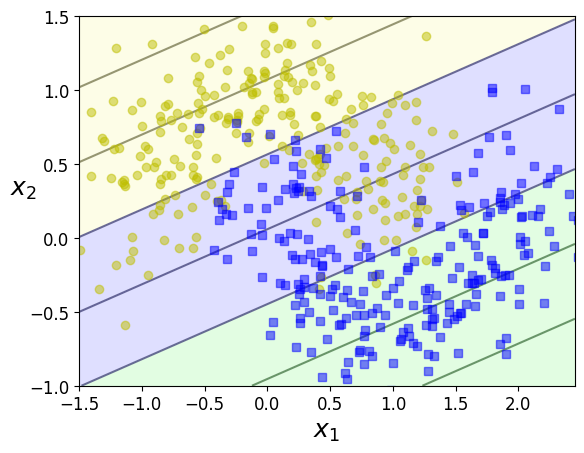

In [75]:
ridgeCV = RidgeCV()
ridgeCV.fit(X_train,y_train,sample_weight=np.where(X_train[:,1]>-0.5,100.0,1.0))

plot_decision_boundary(ridgeCV, X, y)
# plt.axhline(-0.5)

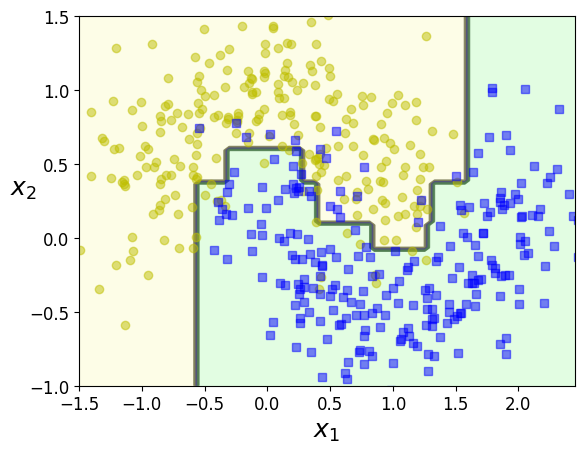

In [76]:
n_estimators=300
#AdaBoostClassifier(base_estimator=SVC/DT/Perceptron/RL,n_estimator= cuantos voy a considerar, algorithm=que algoritmo uso, learning_rate = ,...)
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=n_estimators,
    algorithm="SAMME", learning_rate=0.5, random_state=42)

ada_clf.fit(X_train,y_train)
plot_decision_boundary(ada_clf, X, y)

In [77]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict
preds = cross_val_predict(ada_clf,X_train,y_train)
cm = confusion_matrix(y_train,preds)#,ada_clf.predict(X_train))
print(cm)
print(accuracy_score(y_train,preds))#ada_clf.predict(X_test)))

[[170  19]
 [ 15 171]]
0.9093333333333333


Let's look at the individual estimators, their weights and loss function, computed as

$$ \text{Loss} = \sum_{i}w_{i}\text{Loss}_{i}$$

In [78]:
print(np.asarray(ada_clf.estimators_).shape)

(300,)


[Text(0.5, 0.75, 'x[1] <= -0.091\ngini = 0.497\nsamples = 375\nvalue = [0.541, 0.459]'),
 Text(0.25, 0.25, 'gini = 0.232\nsamples = 118\nvalue = [0.038, 0.244]'),
 Text(0.75, 0.25, 'gini = 0.42\nsamples = 257\nvalue = [0.503, 0.216]')]

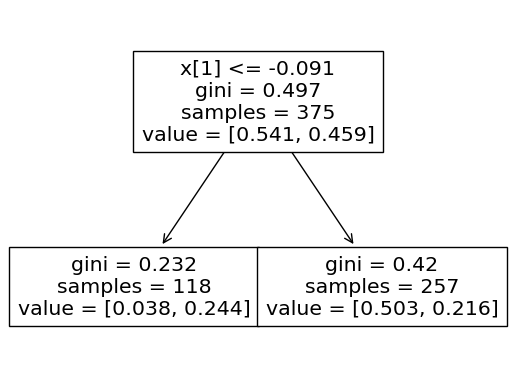

In [79]:
from sklearn.tree import plot_tree
plot_tree(ada_clf.estimators_[1])

(300,)


Text(0, 0.5, 'Weight $\\alpha$')

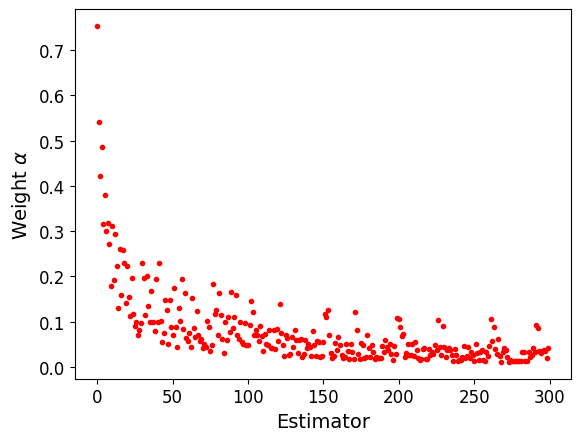

In [82]:
print(ada_clf.estimator_weights_.shape)
plt.plot(ada_clf.estimator_weights_,'r.')
plt.xlabel('Estimator')
plt.ylabel(r'Weight $\alpha$')

(300,)


Text(0, 0.5, 'Loss')

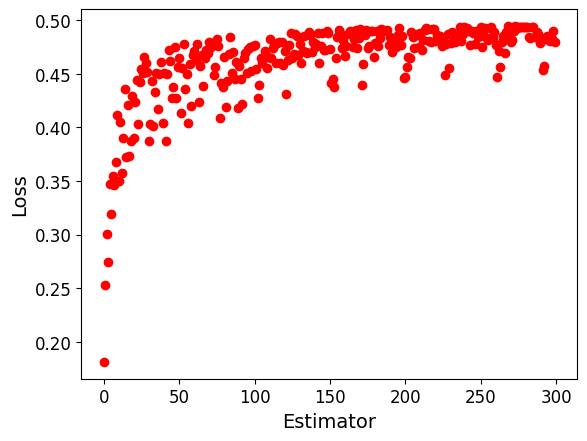

In [81]:
print(ada_clf.estimator_errors_.shape)
plt.plot(ada_clf.estimator_errors_,'ro')
plt.xlabel('Estimator')
plt.ylabel('Loss')

We can explore explicitly the evolution as we add estimators:

In [83]:
for nest, est_pred in enumerate(ada_clf.staged_predict(X_train[:2])):
  print(nest, est_pred[:2])

0 [1 1]
1 [1 1]
2 [1 0]
3 [1 1]
4 [1 0]
5 [1 1]
6 [1 1]
7 [1 1]
8 [1 1]
9 [1 0]
10 [1 1]
11 [1 1]
12 [1 1]
13 [1 1]
14 [1 0]
15 [1 1]
16 [1 1]
17 [1 0]
18 [1 1]
19 [1 0]
20 [1 1]
21 [1 0]
22 [1 0]
23 [1 1]
24 [1 0]
25 [1 0]
26 [1 0]
27 [1 0]
28 [1 0]
29 [1 0]
30 [1 0]
31 [1 0]
32 [1 0]
33 [1 0]
34 [1 0]
35 [1 0]
36 [1 0]
37 [1 0]
38 [1 0]
39 [1 0]
40 [1 0]
41 [1 0]
42 [1 0]
43 [1 0]
44 [1 0]
45 [1 1]
46 [1 0]
47 [1 0]
48 [1 0]
49 [1 0]
50 [1 0]
51 [1 1]
52 [1 0]
53 [1 0]
54 [1 0]
55 [1 0]
56 [1 0]
57 [1 0]
58 [1 0]
59 [1 0]
60 [1 0]
61 [1 0]
62 [1 0]
63 [1 0]
64 [1 0]
65 [1 0]
66 [1 0]
67 [1 0]
68 [1 0]
69 [1 0]
70 [1 0]
71 [1 0]
72 [1 0]
73 [1 0]
74 [1 0]
75 [1 0]
76 [1 0]
77 [1 0]
78 [1 0]
79 [1 0]
80 [1 0]
81 [1 0]
82 [1 0]
83 [1 0]
84 [1 0]
85 [1 0]
86 [1 0]
87 [1 0]
88 [1 0]
89 [1 0]
90 [1 0]
91 [1 0]
92 [1 0]
93 [1 0]
94 [1 0]
95 [1 0]
96 [1 0]
97 [1 0]
98 [1 0]
99 [1 0]
100 [1 0]
101 [1 0]
102 [1 0]
103 [1 0]
104 [1 0]
105 [1 0]
106 [1 0]
107 [1 0]
108 [1 0]
109 [1 0]
110 [1 0]


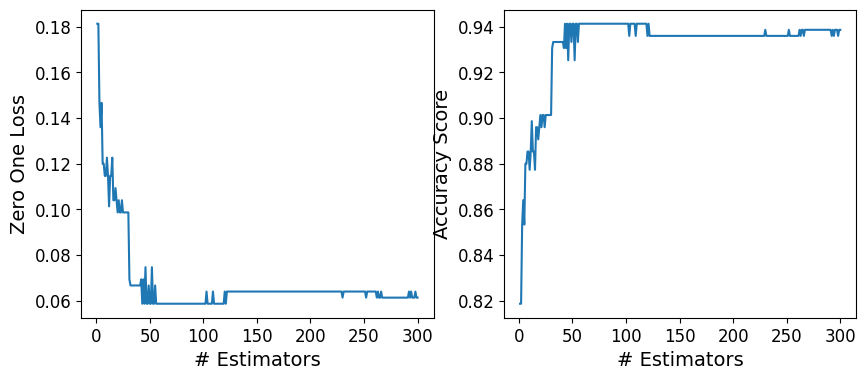

In [84]:
from sklearn.metrics import zero_one_loss #counts the misclassified fraction

err_train = np.zeros((n_estimators,2))
for i, y_pred in enumerate(ada_clf.staged_predict(X_train)):
  err_train[i,0] = zero_one_loss(y_pred, y_train)
  err_train[i,1] = accuracy_score(y_pred, y_train)

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,4))

ax[0].plot(np.arange(n_estimators) + 1, err_train[:,0])
ax[1].plot(np.arange(n_estimators) + 1, err_train[:,1])

ax[0].set_xlabel('# Estimators')
ax[1].set_xlabel('# Estimators')
ax[0].set_ylabel('Zero One Loss')
ax[1].set_ylabel('Accuracy Score')
plt.show()

## Learning rate effect in convergence

A nice example from Geron:

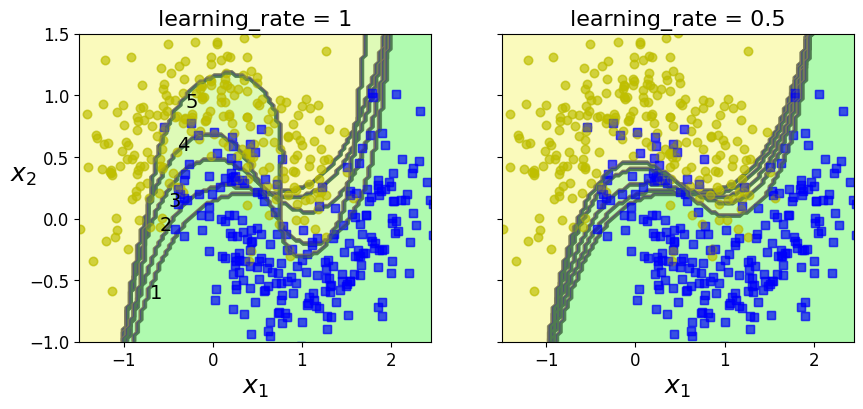

In [85]:
from sklearn.svm import SVC

m = len(X_train)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m)
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.05, gamma="scale", random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)
    else:
        plt.ylabel("")

plt.show()

We can do this for Decision Trees and see the overall evolution

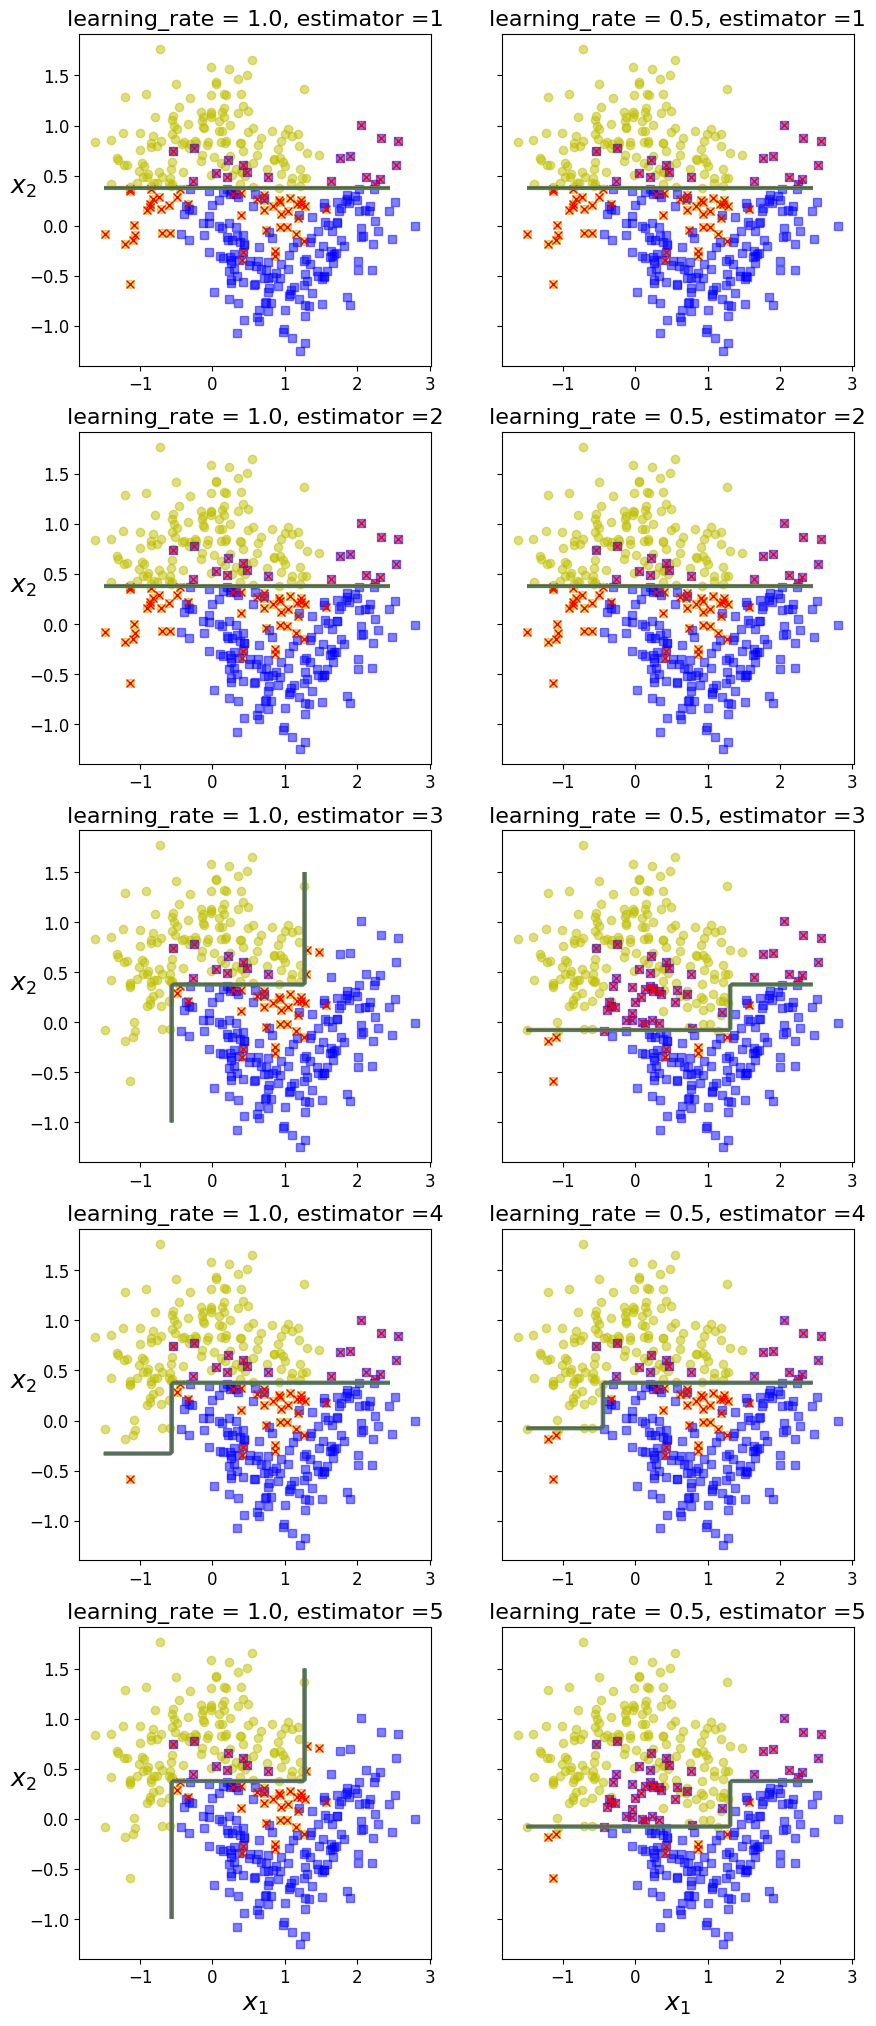

In [86]:
m = len(X_train)

learnings = [1.0,0.5]
fix, axes = plt.subplots(nrows=5,ncols=len(learnings), figsize=(5*len(learnings),25), sharey=True)
for subplot, learning_rate in enumerate(learnings):
    ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=5,
    algorithm="SAMME", learning_rate=learning_rate, random_state=42)
    ada_clf.fit(X_train,y_train)
    y_pred_train=np.zeros((5,X_train.shape[0]))
    for nest_train, est_dec_train in enumerate(ada_clf.staged_predict(X_train)):
      y_pred_train[nest_train]=est_dec_train
    #axes=[-1.5, 2.45, -1, 1.5]
    alpha=0.5
    x1s = np.linspace(-1.5, 2.45, 100)
    x2s = np.linspace(-1, 1.5, 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    for nest, est_dec in enumerate(ada_clf.staged_predict(X_new)):
      y_pred_estimator_only=ada_clf.estimators_[nest].predict(X_new).reshape(x1.shape)
      y_pred = est_dec.reshape(x1.shape)
      custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
      axes[nest,subplot].plot(X_train[:, 0][y_train==0], X_train[:, 1][y_train==0], "yo", alpha=alpha)
      axes[nest,subplot].plot(X_train[:, 0][y_train==1], X_train[:, 1][y_train==1], "bs", alpha=alpha)
      axes[nest,subplot].plot(X_train[:, 0][y_pred_train[nest] != y_train], X_train[:, 1][y_pred_train[nest] != y_train], "rx", alpha=1.0)     
      axes[nest,0].set_ylabel(r"$x_2$", fontsize=18, rotation=0)
      axes[nest,subplot].contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
      #axes[nest,subplot].contour(x1, x2, y_pred_estimator_only, cmap='plasma', alpha=0.8)
      axes[nest,subplot].set_title("learning_rate = {}, estimator ={}".format(learning_rate,nest+1), fontsize=16)
#      plt.show()
    axes[-1,subplot].set_xlabel(r"$x_1$", fontsize=18)
plt.show()

And the individual cuts

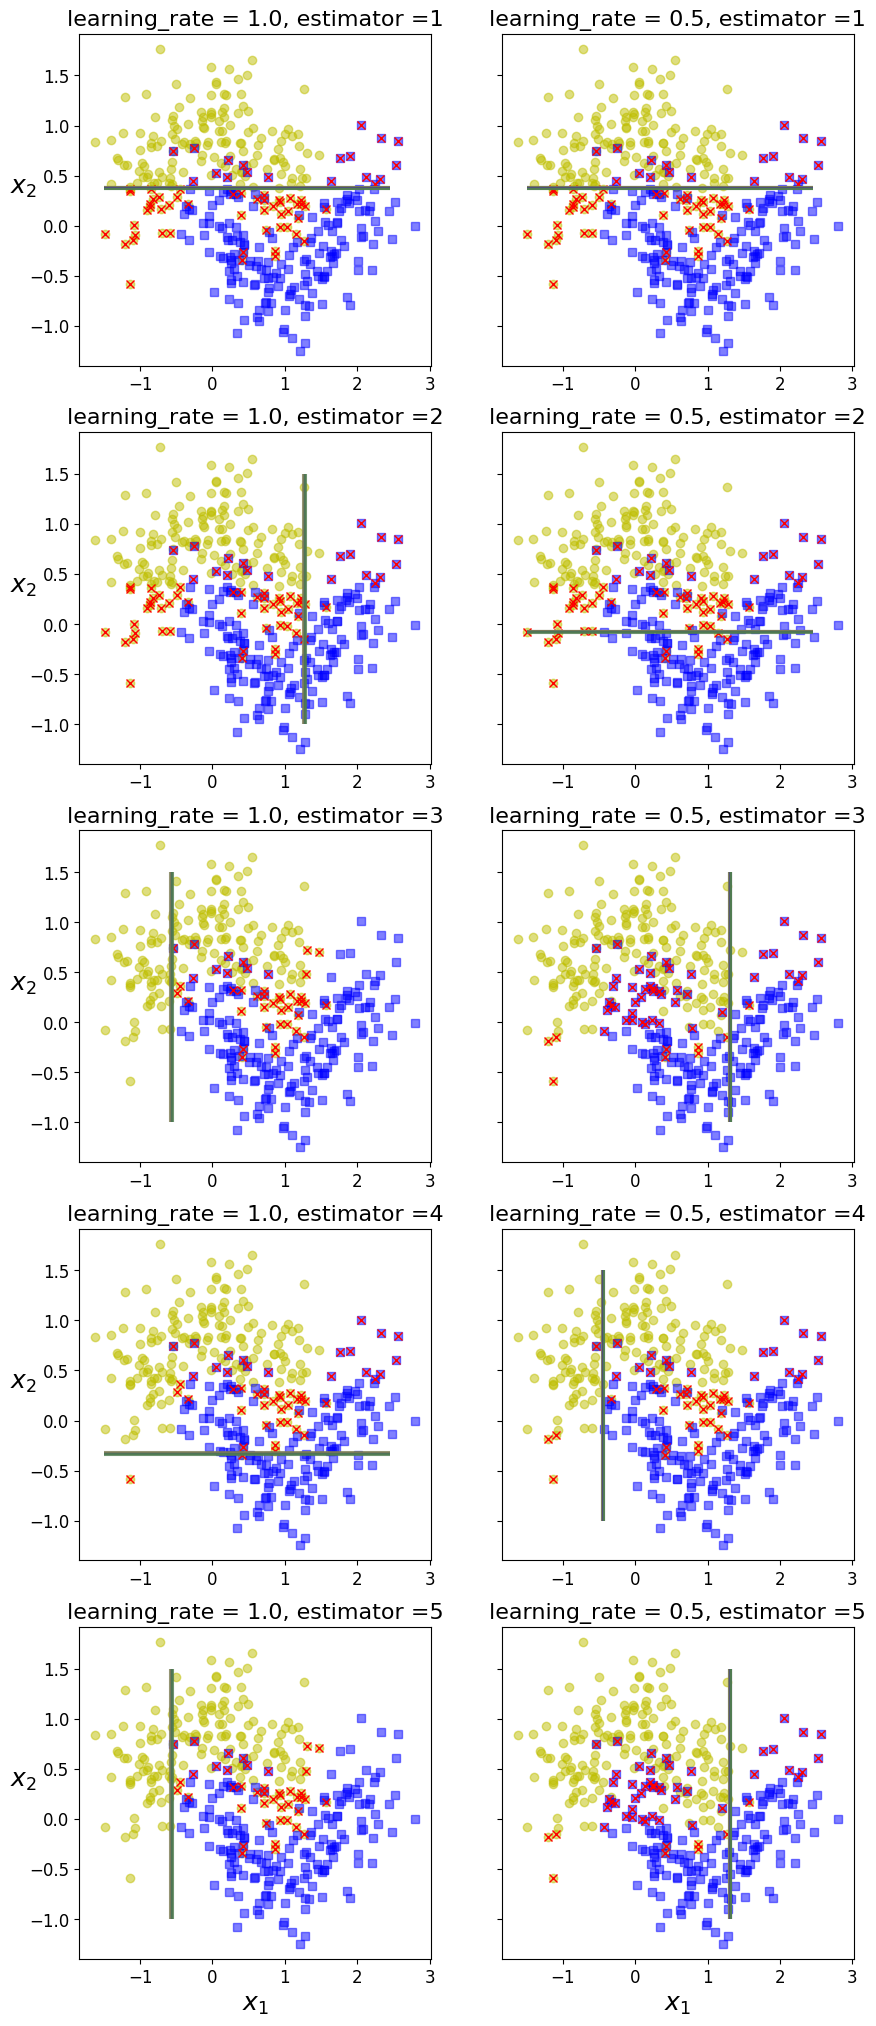

In [87]:
m = len(X_train)

learnings = [1.0,0.5]
fix, axes = plt.subplots(nrows=5,ncols=len(learnings), figsize=(5*len(learnings),25), sharey=True)
for subplot, learning_rate in enumerate(learnings):
    ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=5,
    algorithm="SAMME", learning_rate=learning_rate, random_state=42)
    ada_clf.fit(X_train,y_train)
    y_pred_train=np.zeros((5,X_train.shape[0]))
    for nest_train, est_dec_train in enumerate(ada_clf.staged_predict(X_train)):
      y_pred_train[nest_train]=est_dec_train
    #axes=[-1.5, 2.45, -1, 1.5]
    alpha=0.5
    x1s = np.linspace(-1.5, 2.45, 100)
    x2s = np.linspace(-1, 1.5, 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    for nest, est_dec in enumerate(ada_clf.estimators_):
      y_pred = est_dec.predict(X_new).reshape(x1.shape)
      custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
      axes[nest,subplot].plot(X_train[:, 0][y_train==0], X_train[:, 1][y_train==0], "yo", alpha=alpha)
      axes[nest,subplot].plot(X_train[:, 0][y_train==1], X_train[:, 1][y_train==1], "bs", alpha=alpha)
      axes[nest,subplot].plot(X_train[:, 0][y_pred_train[nest] != y_train], X_train[:, 1][y_pred_train[nest] != y_train], "rx", alpha=1.0)     
      axes[nest,0].set_ylabel(r"$x_2$", fontsize=18, rotation=0)
      axes[nest,subplot].contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
      axes[nest,subplot].set_title("learning_rate = {}, estimator ={}".format(learning_rate,nest+1), fontsize=16)
#      plt.show()
    axes[-1,subplot].set_xlabel(r"$x_1$", fontsize=18)
plt.show()

### Aca un ejemplo comparando algoritmos:

Otra virtud del AdaBoost es el stage_predict y stage_predict_proba, que permite ver como evoluciona el error al ir agregando iteraciones. Utilizemoslo para comparar algoritmos y ver la converfencia.

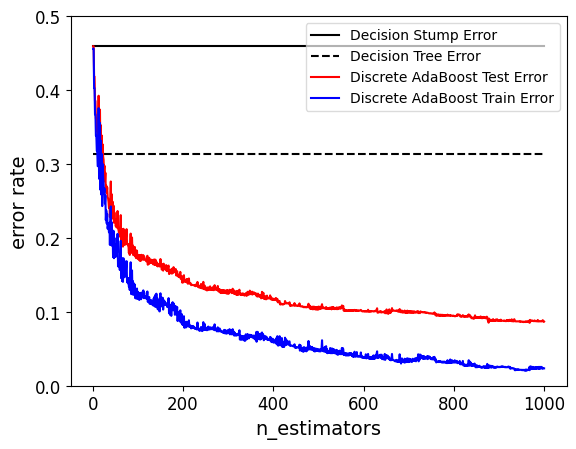

In [88]:
from sklearn.datasets import make_hastie_10_2

n_estimators = 1000
# A learning rate of 1. may not be optimal for both SAMME and SAMME.R
learning_rate = 1.

X, y = make_hastie_10_2(n_samples=12000, random_state=1)

X_test, y_test = X[2000:], y[2000:]
X_train, y_train = X[:2000], y[:2000]

dt_stump = DecisionTreeClassifier(max_depth=1, min_samples_leaf=1)
dt_stump.fit(X_train, y_train)
dt_stump_err = 1.0 - dt_stump.score(X_test, y_test)

dt = DecisionTreeClassifier(max_depth=9, min_samples_leaf=1)
dt.fit(X_train, y_train)
dt_err = 1.0 - dt.score(X_test, y_test)

ada_discrete = AdaBoostClassifier(
    estimator=dt_stump,
    learning_rate=learning_rate,
    n_estimators=n_estimators,
    algorithm="SAMME")
ada_discrete.fit(X_train, y_train)


fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot([1, n_estimators], [dt_stump_err] * 2, 'k-',
        label='Decision Stump Error')
ax.plot([1, n_estimators], [dt_err] * 2, 'k--',
        label='Decision Tree Error')

ada_discrete_err = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_discrete.staged_predict(X_test)):
    ada_discrete_err[i] = zero_one_loss(y_pred, y_test)

ada_discrete_err_train = np.zeros((n_estimators,))
for i, y_pred in enumerate(ada_discrete.staged_predict(X_train)):
    ada_discrete_err_train[i] = zero_one_loss(y_pred, y_train)


ax.plot(np.arange(n_estimators) + 1, ada_discrete_err,
        label='Discrete AdaBoost Test Error',
        color='red')
ax.plot(np.arange(n_estimators) + 1, ada_discrete_err_train,
        label='Discrete AdaBoost Train Error',
        color='blue')

ax.set_ylim((0.0, 0.5))
ax.set_xlabel('n_estimators')
ax.set_ylabel('error rate')

leg = ax.legend(loc='upper right', fancybox=True)
leg.get_frame().set_alpha(0.7)

plt.show()

### Un ejemplo de AdaBoostRegressor

In [ ]:
# Create the dataset
rng = np.random.RandomState(1)
X = np.linspace(0, 6, 100)[:, np.newaxis]
y = np.sin(X).ravel() + np.sin(6 * X).ravel() + rng.normal(0, 0.1, X.shape[0])

# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=4)

regr_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),loss='square',
                          n_estimators=300, random_state=rng)

regr_1.fit(X, y)
regr_2.fit(X, y)

# Predict
y_1 = regr_1.predict(X)
y_2 = regr_2.predict(X)

# Plot the results
plt.figure()
plt.scatter(X, y, c="k", label="training samples")
plt.plot(X, y_1, c="g", label="n_estimators=1", linewidth=2)
plt.plot(X, y_2, c="r", label="n_estimators=300", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Boosted Decision Tree Regression")
plt.legend()
plt.show()

In [ ]:
print(regr_2.estimator_weights_.shape)
plt.plot(regr_2.estimator_weights_,'ro')
plt.xlabel('Iteracion')
plt.ylabel('Peso')

In [ ]:
print(regr_2.estimator_errors_.shape)
plt.plot(regr_2.estimator_errors_,'ro')
plt.xlabel('Iteracion')
plt.ylabel('Error')

## GradientBoosting

Antes de utilizar paquetes especificos veamos un ejemplo del Geron que muestra como funciona Gradient Boosting

### Ejemplo del Geron:

GradientBoosting busca al final hacer algo parecido a lo siguiente.

In [ ]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

y2 = y - tree_reg1.predict(X) #residuos del primer árbol
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

y3 = y2 - tree_reg2.predict(X) #residuos del segundo árbol
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

Y la prediccion seria de esta manera:

In [ ]:
X_new = np.array([[0.8]])
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))#sumo las predicciones
y_pred

Ahora veamoslo de manera grafica

In [ ]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

### La implementacion en `sklearn`

Los dos paquetes de sklearn a utilizar son GradientBoostingClassifier y GradientBoostingRegressor. Los hiperparametros son un poco mas largos de explicar asi que va charlado.


In [ ]:
#GradientBoostingClassifier?

In [ ]:
#GradientBoostingRegressor?

In [ ]:
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=50, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=50, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

In [ ]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

### Eleccion del numero optimo de arboles

Si uno tiene demasiados estimadores, puede sobreajustar. El objetivo es entonces encontrar el numero optimo de estimadores que den un buen ajuste. Esto se puede hacer utilizando lo que se llama **early stopping**. El **early stopping** consiste en utilizar un conjunto de validacion para evaluar el predictor en funcion del numero de estimadores. Si la metrica evaluada en el conjunto de validacion empieza a empeorar, entonces frenamos y nos quedamos con ese numero de estimadores.

In [ ]:

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [np.sqrt(mean_squared_error(y_val, y_pred))
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

In [ ]:
print(bst_n_estimators)

In [ ]:
min_error = np.min(errors)
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([40, 120, 0, 0.1])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

Asi como lo hicimos mas arriba, evitamos un poco mas el sobreajuste. Sin embargo, sigo entrenando con todos los estimadores posibles, lo que es costoso. El early stopping puede incorporarse de manera tal que se detenga al momento en que vea el error de validacion comenzar a subir.

Para eso, utilizo la opcion `warm_start`. Esta opcion almacena los arboles utilizados en `.fit` y permite entrenar de manera incremental.

In [ ]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [ ]:
print(gbrt.n_estimators)
print("Minimo MSE en el conjunto de validacion:", min_val_error)


In [ ]:
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120,warm_start=True, random_state=42,validation_fraction=0.2,n_iter_no_change=5)
gbrt.fit(X,y)

In [ ]:
gbrt.n_estimators

### Stochastic gradient boosting

Hasta ahora no utilizamos el hiperparametro `subsample`.  Este hiperparametro define si entrenamos cada predictor sobre una fraccion elegida al azar de los datos. Esta tecnica baja la varianza todavia mas y acelera el entrenamiento.

In [ ]:
gbrt_all = GradientBoostingRegressor(max_depth=2, n_estimators=100, learning_rate=1.0, random_state=42)
gbrt_all.fit(X, y)

gbrt_stochastic = GradientBoostingRegressor(max_depth=2, n_estimators=100, learning_rate=1.0,subsample=0.5, random_state=42)
gbrt_stochastic.fit(X, y)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt_all], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("subsample={}, n_estimators={}".format(gbrt_all.subsample, gbrt_all.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_stochastic], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("subsample={}, n_estimators={}".format(gbrt_stochastic.subsample, gbrt_stochastic.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

plt.show()

### XGBoost

Extreme Gradient Boosting, o `XGBoost`, es una implementacion optimizada de Gradient Boosting que busca ser rapida, escaleable y portatil. Es muy popular (como se puede ver en kaggle) y puede utilizarse de manera similiar a `sklearn` y se juntan muy bien. En particular, la clase `XBGRegressor` es equivalente un modelo de `sklearn`.

In [ ]:
!pip install xgboost

In [ ]:
from xgboost import XGBRegressor, XGBClassifier

La documentación relevante se encuentra [acá](https://xgboost.readthedocs.io/en/latest/). Los hiperparametros relevantes para nosotros son:

- learning rate (1 por defecto)
- gamma / min_split_loss (0 por defecto): la minima reducción de perdida para que el árbol siga diviendiendo una hoja
- max_depth (6 por defecto)
- min_child_weight (1 por defecto): la minima cantidad de mediciones pesadas que tienen que quedar en un hijo al partir un nodo hoja
- subsample (1 por defecto)
- colsample_bytree, colsample_bylevel, colsample_bynode (1 por defecto los tres): la fracción de features considerados por árbol, por nível y por nodo.
- reg_lambda (1 por defecto): termino de penalización L2 en los pesos
- reg_alpha (0 por defecto): termino de penalización L1 en los pesos
- objective: especifica la tarea a cumplir. 'reg:squarederror' es la pérdida de cuadrados mínimos.  'binary:logistic' o 'multi:softmax'son utiles para clasificación con outputs probabilisticos. Hay varias opciones más para jugar.

In [ ]:
#XGBRegressor?

In [ ]:
import pandas as pd
from sklearn.datasets import load_iris
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = pd.Series(iris.target)
print(X.head())
print(X.info())
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)
X_train_2, X_val, y_train_2, y_val = train_test_split(X_train, y_train,test_size=0.2)

In [ ]:
regressor = XGBRegressor(
    n_estimators=200,
    learning_rate=0.5,
    reg_lambda=0.0,reg_alpha=0.0,
    gamma=0.0,objective='reg:squarederror',
    max_depth=3)

Entrenamos con `fit`, especificando algunos hiperparametros

In [ ]:
regressor.fit(X_train_2,y_train_2,eval_set=[(X_train_2, y_train_2), (X_val, y_val)],
        eval_metric='rmse',early_stopping_rounds=5,#viene con early stopping!
        verbose=True)

In [ ]:
np.sqrt(mean_squared_error(regressor.predict(X_val),y_val))

In [ ]:
regressor.evals_result()

Podemos explorar la importancia de los features:

In [ ]:
for i in range(len(iris.feature_names)):
  print((iris.feature_names[i],regressor.feature_importances_[i]))

Dado que esta tan optimizado y es tan rapido, probemos con `cross_val_score`.

In [ ]:
from sklearn.model_selection import cross_val_score
scores=cross_val_score(regressor,X_train,y_train,scoring='neg_root_mean_squared_error')
print(-scores.mean(),scores.std())

Una vez entrenado, es posible guardar el modelo

In [ ]:
regressor.save_model('xbg_modelo_1.json')

In [ ]:
params=regressor.get_xgb_params()
regressor_2=XGBRegressor(**params)
regressor_2.get_xgb_params()

In [ ]:
regressor_2.load_model('xbg_modelo_1.json')
regressor_2.get_xgb_params()

In [ ]:
regressor.predict(X_train[:2])

In [ ]:
regressor_2.predict(X_train[:2])

## Dataset nuevo

Y agreguemos un dataset más por si quieren probar algo nuevo

En un experimento como el LHC se buscan nuevas particulas (llamémosla $W^\prime$), que decaen no siempre al mismo estado final. Por ejemplo, puede ocurrir que una colisión protón-protón produzca una partícula muy masiva que decae produciendo dos jets (o lluvias de partículas), llamados *leading* y *sub-leading*. Cada uno de estos jets se encuentra caracterizado por  7 parámetros: la masa invariante ($M_j$), el momento transverso ($P_T$), su rapidez relativista ($Y$), su angulo azimutal ($\phi$) y tres variables ($\tau_{21}, \tau_{31}, \tau_{32}$), que miden cuánta subestructura posee cada jet.

Contamos con un conjunto de datos de 10000 colisiones donde efectivamente se produce esta partícula nueva ($W^\prime$, que llamamos *señal*) y otros 10000 donde la colisión no llevo a la creación de esta partícula (pero sí de muchas otras, que no son de interés). Estos últimos eventos constituyen entonces el *background* de la medición. 

El objetivo es usar las características de los jets para clasificar las colisiones de las cuales provienen en las dos clases: *señal* o *background*.

El siguiente codigo importa los datos y hace una visualización. No hace falta que hagan más gráficos, pero son bienvenidos a explorar los datos en mayor detalle.

In [90]:
housing_path='datasets'
link_signal = ''
link_background = ''
os.makedirs(housing_path, exist_ok=True)
# Para lxs que estén en colab; si trabajás en local, deberías tener los datos accesibles al haber clonado el repo.
if 'google.colab' in sys.modules:
    #Para descargar los datos al directorio actual, ejecute la siguiente linea
    !wget link_signal -P {housing_path}
    !wget link_background -P {housing_path}

In [91]:
background=[]
# Lee los eventos de background
with open('datasets/np_background.dat') as backgroundfile:
  for nline, line in enumerate(backgroundfile):
    if(nline<10000):
      Line=line.split(";")
      # separa los datos del jet *leading* de los del jet *sub-leading*, los transforma en float
      # y construye un array de dimensiones [10000, 2, 7] (evento, jet, feature)
      background_1=list(map(lambda x: float(x), Line[0].split(',')))
      background_2=list(map(lambda x: float(x), Line[1].split(',')))
      background.append([background_1,background_2])
    
background=np.asarray(background)

# Hace lo mismo para los datos de la señal.
signal=[]
with open('datasets/np_signal.dat') as signalfile:
  for nline,line in enumerate(signalfile):
    if(nline<10000):
      Line=line.split(";")
      signal_1=list(map(lambda x: float(x),Line[0].split(',')))
      signal_2=list(map(lambda x: float(x),Line[1].split(',')))
      signal.append([signal_1,signal_2])
signal=np.asarray(signal)

print('Shape de background y señal:', background.shape, signal.shape)

# Combina los datos de backgroud y señal de cada jet, asigna labels 0 = background y 1 = señal
X = np.vstack((background, signal))
Y = np.hstack((np.zeros(len(background)), np.ones(len(signal))))

print('Shape de datos y labels:', X.shape, Y.shape)

Shape de background y señal: (10000, 2, 7) (10000, 2, 7)
Shape de datos y labels: (20000, 2, 7) (20000,)


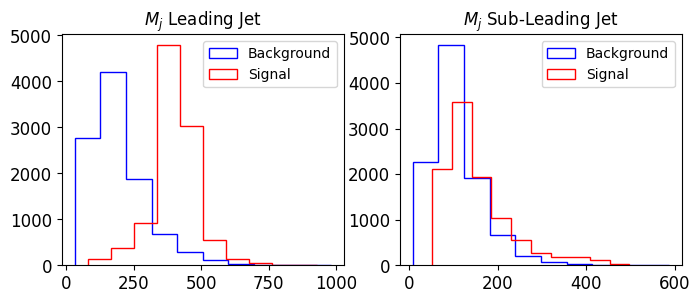

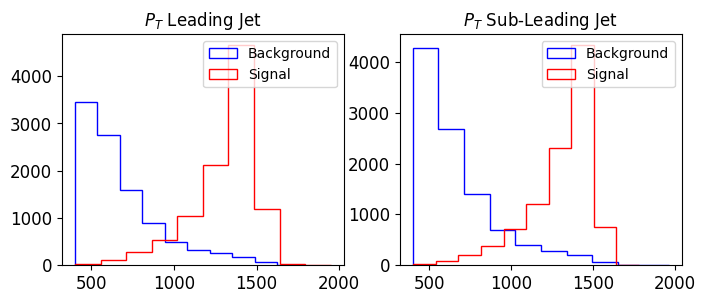

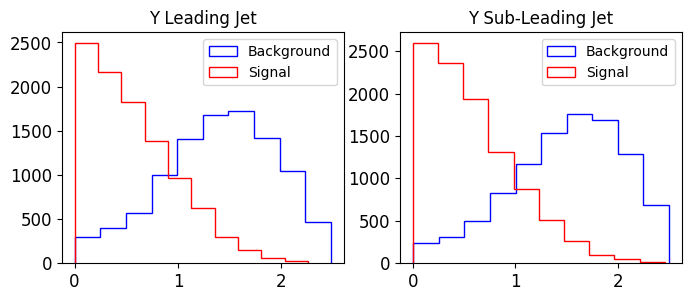

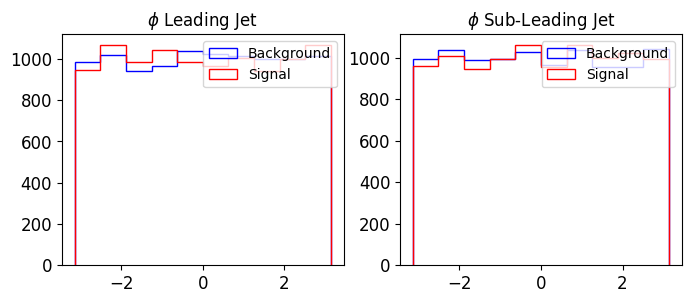

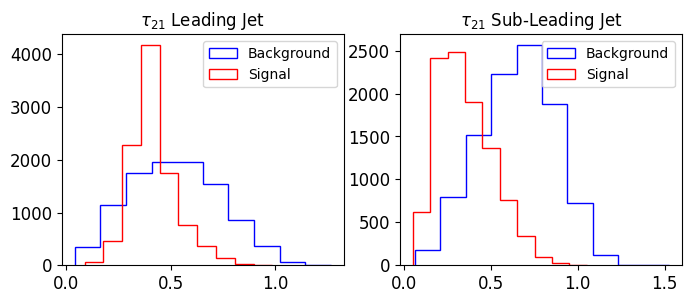

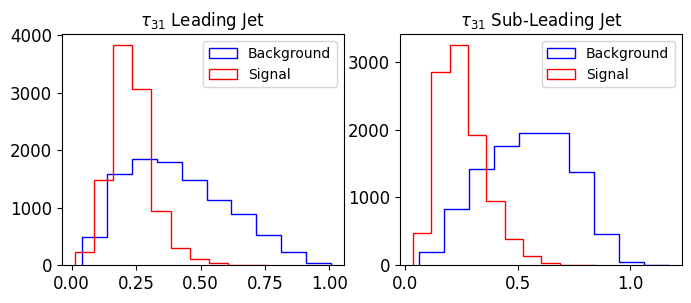

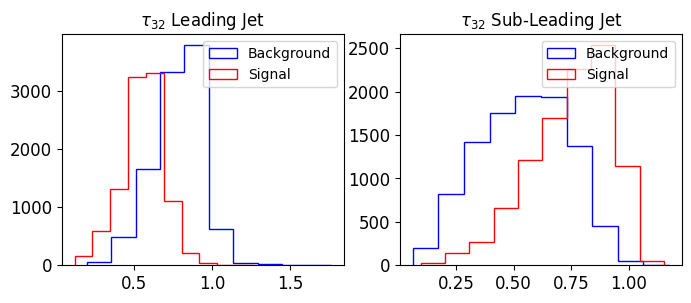

In [92]:
import matplotlib.pyplot as plt
vars=['$M_j$','$P_T$','Y','$\phi$',r'$\tau_{21}$',r'$\tau_{31}$',r'$\tau_{32}$']

# Hacemos un histograma de cada variable por separado, para cada jet y cada clase.
for i in range(7):
  fig, axs = plt.subplots(1,2,figsize=(8,3))
  axs[0].hist(background[:,0,i],histtype='step',color='blue',label='Background')
  axs[0].hist(signal[:,0,i],histtype='step',color='red',label='Signal')
  axs[0].legend(loc='upper right')
  axs[0].set_title(vars[i]+' Leading Jet')
  axs[1].hist(background[:,1,i],histtype='step',color='blue',label='Background')
  axs[1].hist(signal[:,1,i],histtype='step',color='red',label='Signal')
  axs[1].legend(loc='upper right')
  axs[1].set_title(vars[i]+' Sub-Leading Jet')
  plt.show()

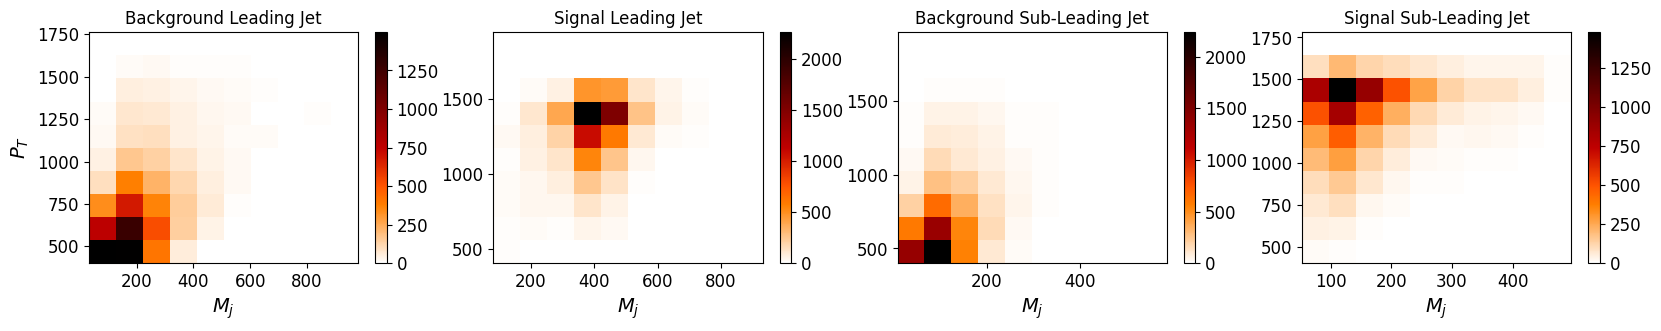

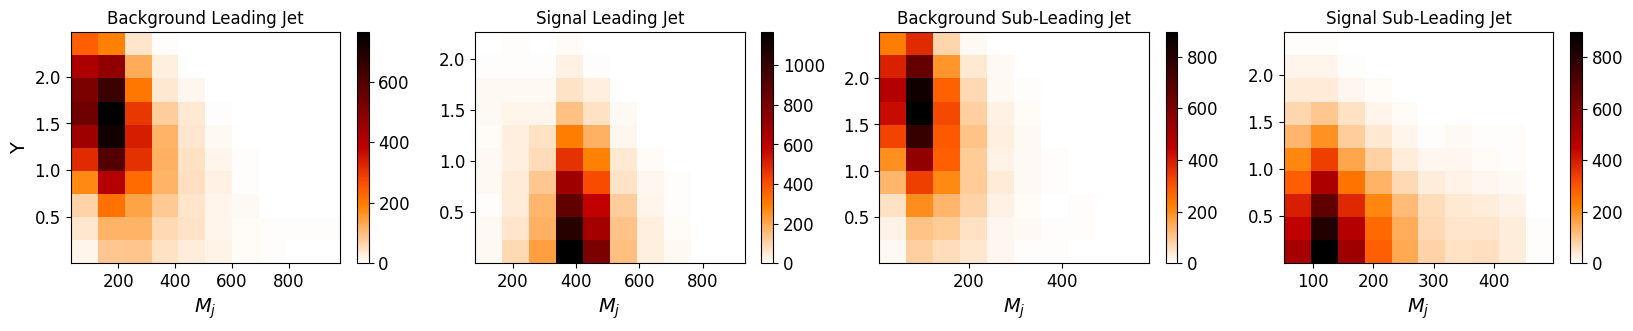

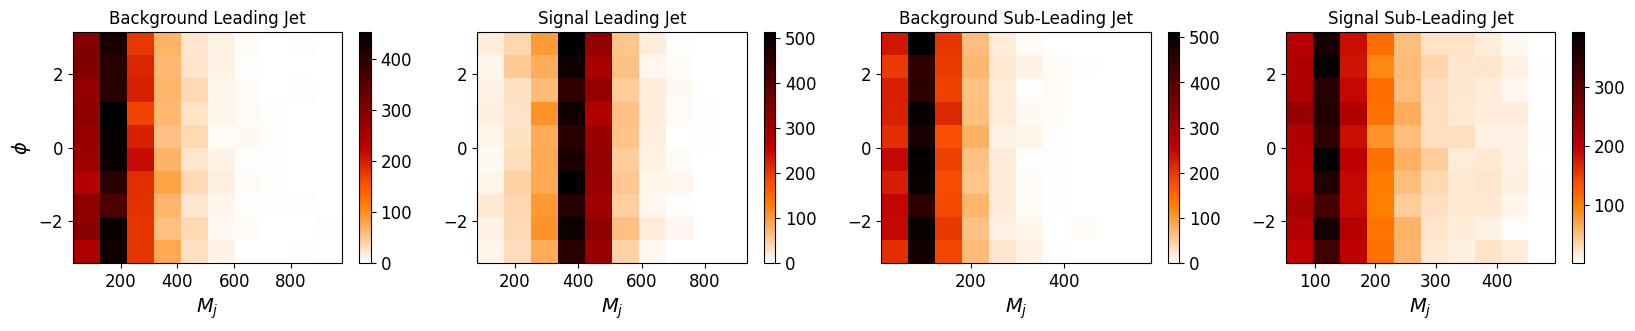

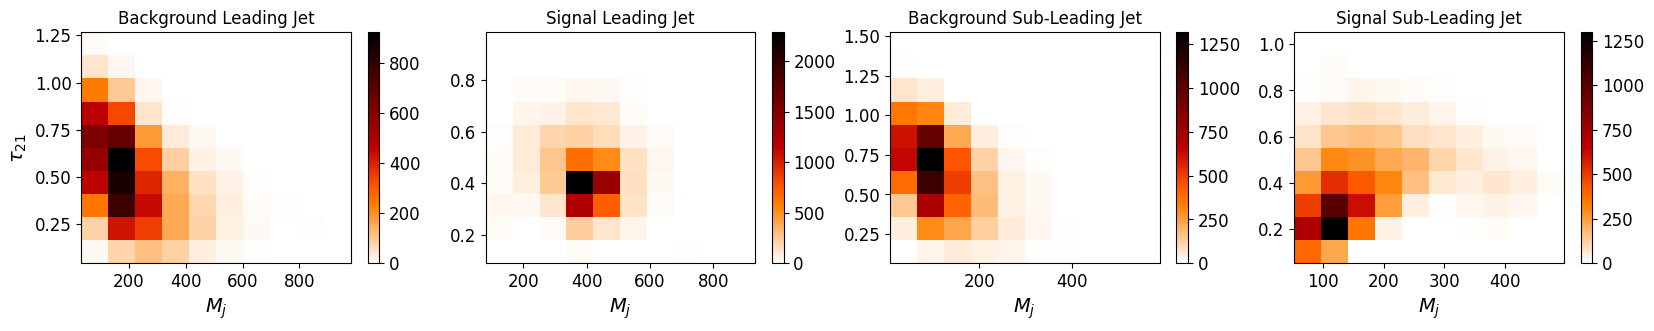

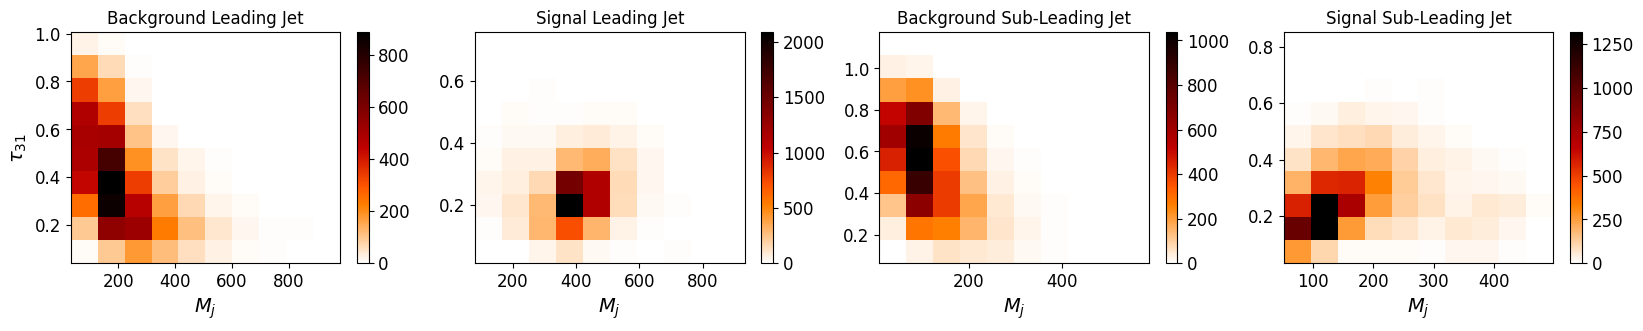

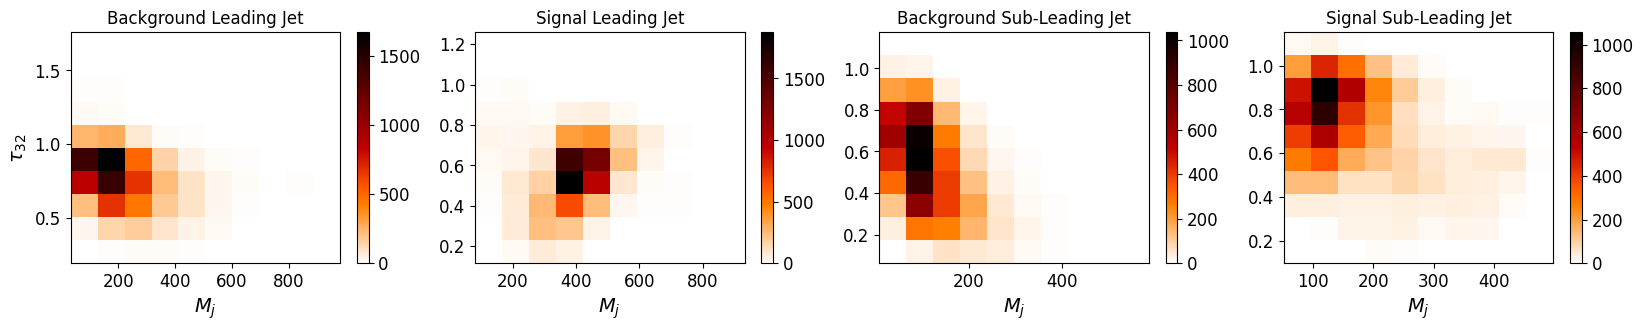

In [93]:
# Mostramos correlaciones de los parámetros de cada jet con la masa invariante.
for i in range(6):
  fig, axs = plt.subplots(1,4,figsize=(20,3))
  f1=axs[0].hist2d(background[:,0,0],background[:,0,1+i],cmap='gist_heat_r')
  fig.colorbar(f1[3], ax=axs[0])
  axs[0].set_xlabel(vars[0])
  axs[0].set_ylabel(vars[1+i])
  axs[0].set_title('Background Leading Jet')
  f2=axs[1].hist2d(signal[:,0,0],signal[:,0,1+i],cmap='gist_heat_r')
  fig.colorbar(f2[3], ax=axs[1])
  axs[1].set_xlabel(vars[0])
  #axs[1].set_ylabel(vars[1+i])
  axs[1].set_title('Signal Leading Jet')
  f3=axs[2].hist2d(background[:,1,0],background[:,1,1+i],cmap='gist_heat_r')
  fig.colorbar(f3[3], ax=axs[2])
  axs[2].set_xlabel(vars[0])
  axs[2].set_title('Background Sub-Leading Jet')
  f4=axs[3].hist2d(signal[:,1,0],signal[:,1,1+i],cmap='gist_heat_r')
  axs[3].set_xlabel(vars[0])
  axs[3].set_title('Signal Sub-Leading Jet')
  fig.colorbar(f4[3], ax=axs[3])
  plt.show()

Para estos datos, entrenen un Clasificador con Boosting para cada jet por separado y para ambos jets en conjunto. Obtenga las feature importances en cada caso. Comparen con un clasificador simple para decidir si valió la pena hacer Boosting.

In [ ]:
###START_EXERCISE
# You can add your solution in this code cell.
###STOP_EXERCISE

In [ ]:
###START_SOLUTION
###STOP_SOLUTION